# Thesis Benchmark Implementation: Robust Deep Learning

This notebook implements the baseline algorithms for comparison against the proposed algorithm.

The goal is to reproduce the performance of standard and existing robust methods on datasets with known noise.

## 1. Imports

We'll begin by importing the necessary libraries from PyTorch, TorchVision, and NumPy.



In [17]:
# --- 1. Imports ---

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm.notebook import tqdm  # For progress bars

# Set a random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# --- Updated Device Setup ---
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
elif torch.backends.mps.is_available():
    # This is for Apple's M-series chips
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: mps


In [17]:
# --- Mount Drive (Colab) or Define Local Path (Local) ---
import os

# Check if we are in Google Colab
try:
    import google.colab
    IS_COLAB = True
except ImportError:
    IS_COLAB = False

if IS_COLAB:
    print("Running on Google Colab. Mounting Drive...")
    from google.colab import drive
    drive.mount('/content/drive')
    # Use the Google Drive path
    checkpoint_dir = '/content/drive/MyDrive/ThesisCheckpoints'
else:
    print("Running locally. Using local checkpoint directory.")
    # Use a local folder named 'ThesisCheckpoints' in your notebook's directory
    checkpoint_dir = './ThesisCheckpoints'

# --- This part is the same for both ---
# Ensure the directory exists
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
    print(f"Created directory: {checkpoint_dir}")
else:
    print(f"Checkpoint directory already exists: {checkpoint_dir}")

Running locally. Using local checkpoint directory.
Checkpoint directory already exists: ./ThesisCheckpoints


In [2]:
## 1.1 Data Setup: Download Cloud Dataset (Task 2)
# PURPOSE: Downloads and unzips the dataset. Requires kaggle.json in the file system.

import os

def download_cloud_data():
    dataset_name = "zeesolver/cloiud-dataset"
    target_dir = "./data/task_2_clouds"
    
    # Check if data already exists to avoid re-downloading
    if os.path.exists(target_dir) and len(os.listdir(target_dir)) > 0:
        print(f"✅ Dataset already found at {target_dir}")
        return

    print(f"⬇️ Downloading {dataset_name}...")
    
    # Install Kaggle client if missing
    os.system("pip install -q kaggle")
    
    # Set config dir to current directory if kaggle.json is here
    if os.path.exists("kaggle.json"):
        os.environ['KAGGLE_CONFIG_DIR'] = os.getcwd()
    
    # Download and unzip
    # -d: dataset, -p: path, --unzip: automatic unzip
    ret = os.system(f"kaggle datasets download -d {dataset_name} -p {target_dir} --unzip")
    
    if ret == 0:
        print("✅ Download and unzip complete.")
    else:
        print("❌ Download failed. Make sure 'kaggle.json' is uploaded to the runtime.")

download_cloud_data()

⬇️ Downloading zeesolver/cloiud-dataset...



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
/Users/selim/Desktop/**WS2526/Thesis/Implementation Trials/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Dataset URL: https://www.kaggle.com/datasets/zeesolver/cloiud-dataset
License(s): apache-2.0



100%|██████████| 5.10M/5.10M [00:00<00:00, 1.01GB/s]


✅ Download and unzip complete.


In [3]:
## 1.2 Analysis: Calculate Signal Power (E[x^2])
# PLACE THIS: After the download cell.
# PURPOSE: Measures the strength of the clean signal so we can calibrate the noise.

import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

def get_signal_power(data_path, img_size=64):
    print(f"📊 Analyzing signal power in: {data_path}")
    
    # Transform: Resize to 64x64 and convert to Tensor (0-1)
    # We do NOT normalize (subtract mean) here because we need raw energy.
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor()
    ])
    
    try:
        # Load dataset
        ds = ImageFolder(root=data_path, transform=transform)
        dl = DataLoader(ds, batch_size=64, shuffle=False)
        
        squared_sum = 0.0
        count = 0
        
        for imgs, _ in dl:
            # imgs: [batch, 3, 64, 64]
            squared_sum += torch.sum(imgs ** 2).item()
            count += imgs.numel()
            
        power = squared_sum / count
        print(f"✅ Signal Power (E[x^2]): {power:.5f}")
        return power
    
    except Exception as e:
        print(f"⚠️ Could not load dataset: {e}")
        return 0.5 # Default fallback

# Calculate
dataset_path = "./data/task_2_clouds"
signal_power = get_signal_power(dataset_path)


## 1.3 Analysis: Calibrate Gaussian Noise Variance
# PLACE THIS: After calculating signal power.
# PURPOSE: Decides the noise std to ensure the task is "Hard" (SNR < 0.5).

def calibrate_noise(signal_pow):
    print("\n⚖️ Calibrating Noise Levels...")
    stds = [0.1, 0.3, 0.5, 0.8, 1.0, 1.2]
    
    recommended_std = 0.5
    
    print(f"{'STD':<6} | {'NoiseVar':<8} | {'SNR':<8} | {'Difficulty'}")
    print("-" * 45)
    
    for s in stds:
        noise_var = s ** 2
        snr = signal_pow / noise_var
        
        diff = "EASY"
        if snr < 0.2: diff = "CRITICAL"
        elif snr < 0.5: 
            diff = "HARD (Target)"
            if recommended_std == 0.5: recommended_std = s # Pick first hard one
        elif snr < 1.0: diff = "MEDIUM"
            
        print(f"{s:<6.1f} | {noise_var:<8.2f} | {snr:<8.2f} | {diff}")
        
    print(f"\n🎯 Recommended Noise Std for Task 2: {recommended_std}")
    return recommended_std

selected_noise_std = calibrate_noise(signal_power)

📊 Analyzing signal power in: ./data/task_2_clouds
✅ Signal Power (E[x^2]): 0.33258

⚖️ Calibrating Noise Levels...
STD    | NoiseVar | SNR      | Difficulty
---------------------------------------------
0.1    | 0.01     | 33.26    | EASY
0.3    | 0.09     | 3.70     | EASY
0.5    | 0.25     | 1.33     | EASY
0.8    | 0.64     | 0.52     | MEDIUM
1.0    | 1.00     | 0.33     | HARD (Target)
1.2    | 1.44     | 0.23     | HARD (Target)

🎯 Recommended Noise Std for Task 2: 1.0


## 2. Baseline 1: Uniform SGD

This is the standard, non-robust training procedure. It serves as our main baseline.

* **Method:** Standard Stochastic Gradient Descent.
* **Sampling:** Samples are drawn *uniformly at random* from the entire training dataset in each epoch (as handled by the default `DataLoader`).


In [18]:
# --- 2. Baseline 1: Uniform SGD ---

def train_uniform_sgd(model, train_loader, criterion, optimizer, device):
    """
    Standard training loop for one epoch using Uniform SGD.
    non-robust baseline.
    """
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_samples = 0
    total_samples = 0

    # The default train_loader already implements uniform random sampling
    # (with shuffling enabled)
    for inputs, labels in train_loader:

        # Move data to the configured device
        inputs, labels = inputs.to(device), labels.to(device)

        # 1. Zero the parameter gradients
        optimizer.zero_grad()

        # 2. Forward pass
        outputs = model(inputs)

        # 3. Calculate the loss
        # Note: We use the raw, unreduced loss for potential future per-sample analysis,
        # but for the step, we need the mean.
        # For Uniform SGD, we just use the standard reduction ('mean').
        # We ensure the criterion is set to 'mean' reduction outside this function.
        loss = criterion(outputs, labels)

        # 4. Backward pass
        loss.backward()

        # 5. Optimize
        optimizer.step()

        # --- Statistics ---
        running_loss += loss.item() * inputs.size(0)

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_samples += (predicted == labels).sum().item()

    epoch_loss = running_loss / total_samples
    epoch_acc = correct_samples / total_samples

    return epoch_loss, epoch_acc

## 3. Baseline 2: Min-k Loss SGD (MKL-SGD)

This is the first robust baseline, based on the paper **"Choosing the Sample with Lowest Loss makes SGD Robust"**.

* **Method:** This algorithm is a simple variant of SGD. The core idea is that noisy samples or outliers will often have a high loss.
* **Algorithm (Theoretical):** The paper's `Algorithm 1`  defines the process:
    1.  Choose a set $S_t$ of $k$ samples.
    2.  Find the single sample $i_t$ in that set with the *minimum* loss: $i_t = \arg \min_{i \in S_t} f_i(w_t)$.
    3.  [cite_start]Perform a standard SGD update using *only* that one sample: $w_{t+1} = w_t - \eta \nabla f_{i_t}(w_t)$.
* **Algorithm (Practical Batch Variant):**
    For deep learning, updating on a single sample is inefficient. The paper describes a "more practical batched variant" for its neural network experiments[cite: 355]. We will implement this version.
    1.  Load a mini-batch of size $b$.
    2.  Calculate the per-sample loss for all $b$ samples.
    3.  Instead of just picking 1, we select the $m$ samples with the lowest loss. Based on the paper's experiments (e.g., "if $k=2$ the algorithm picks $b/2$ samples" [cite: 355]), we will use a parameter `k_ratio` to define this.
    4.  $m = \text{int}(b / \text{k\_ratio})$.
    5.  The final loss to be backpropagated is the **mean** of these $m$ selected low-loss samples.



In [19]:
# --- 3. Baseline 2: MKL-SGD ---

def train_mkl_sgd(model, train_loader, criterion_nored, optimizer, device, k_ratio=2.0):
    """
    Training loop for one epoch using Min-k Loss SGD (MKL-SGD).
    Based on the "practical batched variant" from the paper[cite: 355].

    Args:
        model: The neural network.
        train_loader: DataLoader for training data.
        criterion_nored: Loss function (e.g., CrossEntropyLoss)
                         initialized with `reduction='none'`.
        optimizer: The optimizer (e.g., SGD, Adam).
        device: The device to run on (cpu or cuda).
        k_ratio: The denominator for sample selection (e.g., 2.0 means b/2 samples).
    """
    model.train()
    running_selected_loss = 0.0
    correct_samples = 0
    total_samples = 0
    total_selected_samples = 0

    for inputs, labels in train_loader:

        inputs, labels = inputs.to(device), labels.to(device)
        batch_size = inputs.size(0)

        # Determine number of samples to select (m = b/k)
        # Ensure we select at least one sample
        num_to_select = int(batch_size / k_ratio)
        if num_to_select == 0:
            num_to_select = 1

        # 1. Zero the parameter gradients
        optimizer.zero_grad()

        # 2. Forward pass
        outputs = model(inputs)

        # 3. Calculate per-sample loss (reduction='none' is required)
        per_sample_loss = criterion_nored(outputs, labels)

        # 4. Select the m = b/k samples with the lowest loss
        sorted_loss, sorted_indices = torch.sort(per_sample_loss)
        selected_loss = sorted_loss[:num_to_select]

        # 5. Calculate the mean loss *only* for the selected samples
        mean_selected_loss = selected_loss.mean()

        # 6. Backward pass and optimize on the selected mean loss
        mean_selected_loss.backward()
        optimizer.step()

        # --- Statistics ---
        # We track the loss of the selected samples
        running_selected_loss += selected_loss.sum().item()
        total_selected_samples += num_to_select

        # Accuracy is calculated on the entire batch for a fair comparison
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_samples += (predicted == labels).sum().item()

    # Average loss over all *selected* samples
    epoch_loss = running_selected_loss / total_selected_samples

    # Average accuracy over *all* processed samples
    epoch_acc = correct_samples / total_samples

    return epoch_loss, epoch_acc

## 4. Baseline 3: Reducible Holdout Loss (RHO-LOSS)

This is the second robust baseline, based on the paper **"Prioritized Training on Points that are learnable, Worth Learning, and Not Yet Learnt"**.

* **Motivation:** The paper argues that:
    1.  Selecting "hard" points (high loss), like MKL-SGD, often backfires because these points are frequently *noisy* (unlearnable) or *outliers* (less relevant).
    2.  Selecting "easy" points (curriculum learning) is inefficient as it wastes compute on *redundant* samples that the model has already learned.
* **Goal:** RHO-LOSS aims to select points that are **learnable** (not noisy), **worth learning** (not outliers), and **not yet learnt** (not redundant).
* **Method (Algorithm 1):** The algorithm uses two models:
    1.  The main **Target Model** (the one we are training).
    2.  A separate **Irreducible Loss (IL) Model**.

* **Algorithm Steps:**

    **Phase 1: Pre-Computation (Done Once)**
    1.  A holdout set $\mathcal{D}_{ho}$ is set aside.
    2.  The **IL Model** is trained *only* on this holdout set $\mathcal{D}_{ho}$.
    3.  We then perform a *single forward pass* of the entire training dataset through the (frozen) **IL Model** to calculate the loss for every single training sample $(x_i, y_i)$ .
    4.  This loss, $L[y_i|x_i; \mathcal{D}_{ho}]$, is called the **Irreducible Loss (IL)**. It represents the "unlearnable" part of the sample, (e.g., noise). These values are stored in an array.

    **Phase 2: Main Training Loop**
    1.  At each step, a large "candidate" batch $B_t$ (size $n_B$) is loaded.
    2.  The **Target Model** calculates the *current training loss* for each sample in $B_t$: $L[y_i|x_i; \mathcal{D}_{t}]$.
    3.  The **RHO-LOSS score** is computed for each sample:
        `RHO-LOSS[i] = Current_Loss[i] - IL[i]`.
    4.  The algorithm selects the $n_b$ samples with the **highest** RHO-LOSS scores.
    5.  A gradient step is performed using the *mean* of the `Current_Loss` (not the RHO-LOSS) of these $n_b$ selected samples.

In [ ]:
# --- 4. Baseline 3: RHO-LOSS (Phase 1: IL Pre-computation) ---

def compute_irreducible_loss(il_model, train_dataset, criterion_nored, device, batch_size=128):
    """
    Computes the Irreducible Loss (IL) for every sample in the train_dataset
    using the pre-trained il_model.

    Args:
        il_model: The pre-trained Irreducible Loss model.
        train_dataset: The *entire* training dataset object.
        criterion_nored: Loss function (reduction='none').
        device: CPU or CUDA.
        batch_size: Batch size for this one-time forward pass.

    Returns:
        A NumPy array containing the IL for each training sample, in order.
    """
    il_model.eval()  # Set IL model to evaluation mode
    all_il_losses = []

    # Use a DataLoader to process the dataset efficiently
    # IMPORTANT: shuffle=False to maintain dataset order
    il_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    print("Computing Irreducible Losses (IL) for all training samples...")
    with torch.no_grad():  # No gradients needed

        # --- THE FIX IS HERE ---
        # The loader yields (data, label, index). We must unpack all three.
        # We can use '_' to ignore the index.
        for inputs, labels, _ in tqdm(il_loader, desc="IL Computation"):
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass through the IL model
            outputs = il_model(inputs)

            # Calculate per-sample loss
            loss = criterion_nored(outputs, labels)

            all_il_losses.append(loss.cpu())

    # Concatenate all batch losses into a single tensor
    il_loss_map = torch.cat(all_il_losses).numpy()

    # Add a check to make sure the map size matches the dataset
    if len(il_loss_map) != len(train_dataset):
        print(f"Warning: IL map size ({len(il_loss_map)}) does not match"
              f" dataset size ({len(train_dataset)}). Check for errors.")

    print(f"Computed IL map with shape: {il_loss_map.shape}")
    return il_loss_map

In [21]:
# --- 4. Baseline 3: RHO-LOSS (Phase 2: Training Loop) ---

def train_rho_loss(model, il_loss_map, train_loader, criterion_nored, optimizer, device, selection_ratio=0.1):
    """
    Training loop for one epoch using RHO-LOSS selection.

    Args:
        model: The main target model to train.
        il_loss_map: The NumPy array of pre-computed Irreducible Losses.
        train_loader: DataLoader. IMPORTANT: Must yield (inputs, labels, indices).
        criterion_nored: Loss function (reduction='none').
        optimizer: The optimizer.
        device: CPU or CUDA.
        selection_ratio: Ratio of samples to select (nb / nB).
                         [cite: 1052] (e.g., 0.1 for 10%)
    """
    model.train()
    running_selected_loss = 0.0
    correct_samples = 0
    total_samples = 0
    total_selected_samples = 0

    # Convert IL map to a tensor on the correct device for fast lookup
    il_loss_map_tensor = torch.tensor(il_loss_map, dtype=torch.float32).to(device)

    for inputs, labels, indices in train_loader:

        inputs, labels = inputs.to(device), labels.to(device)
        indices = indices.to(device)

        batch_size_nB = inputs.size(0)  # This is n_B (large batch size)

        # Determine number of samples to select (n_b)
        num_to_select_nb = int(batch_size_nB * selection_ratio)
        if num_to_select_nb == 0:
            num_to_select_nb = 1

        # 1. Zero the parameter gradients
        optimizer.zero_grad()

        # 2. Forward pass (Target Model)
        outputs = model(inputs)

        # 3. Calculate *current* per-sample loss: L[y|x; D_t]
        current_loss_per_sample = criterion_nored(outputs, labels)

        # 4. Look up pre-computed Irreducible Loss: L[y|x; D_ho]
        # We use the indices to get the correct IL for each sample in the batch
        batch_il_loss = il_loss_map_tensor[indices]

        # 5. Compute RHO-LOSS score: L[D_t] - L[D_ho]
        rho_loss_per_sample = current_loss_per_sample - batch_il_loss

        # 6. Select the top-nb samples with the *highest* RHO-LOSS score
        # We get the indices *within the batch* of the top samples
        _, top_batch_indices = torch.topk(rho_loss_per_sample, num_to_select_nb)

        # 7. Get the *current loss* (not RHO-LOSS) for the selected samples
        # The gradient is computed on the actual loss of the selected samples
        selected_current_loss = current_loss_per_sample[top_batch_indices]

        # 8. Calculate the mean loss for the backward pass
        mean_selected_loss = selected_current_loss.mean()

        # 9. Backward pass and optimize
        mean_selected_loss.backward()
        optimizer.step()

        # --- Statistics ---
        running_selected_loss += selected_current_loss.sum().item()
        total_selected_samples += num_to_select_nb

        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_samples += (predicted == labels).sum().item()

    epoch_loss = running_selected_loss / total_selected_samples
    epoch_acc = correct_samples / total_samples

    return epoch_loss, epoch_acc

## 5. Data Preparation & Noise Injection

To run the experiments, we need to load `CIFAR-100` and `MNIST`.

We will create a custom PyTorch `Dataset` class that wraps the standard `torchvision` datasets. This new class will have two key features:

1.  **Noise Injection:** During initialization, it will check for a `noise_rate` (e.g., 0.2 for 20%) and a `noise_type` (e.g., 'symmetric'). If specified, it will permanently corrupt the specified percentage of labels for the entire training run.
2.  **Index Tracking:** The `__getitem__` method will be modified to return `(data, label, index)`. This index is **essential** for `RHO-LOSS` (to look up the Irreducible Loss) and for your proposed `HASA` (to track the historical loss of each sample).

We will also add a `transforms` hook to add *input noise* (like Gaussian noise) for the MNIST experiment.

In [4]:
# --- 5. Custom Dataset for Noise & Indexing ---
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import CIFAR100, MNIST, ImageFolder
import numpy as np
import torch
from tqdm import tqdm
import os

class NoisyIndexedDataset(Dataset):
    """
    Wraps a torchvision dataset (e.g., CIFAR100, MNIST) or a directory-based dataset (CLOUD) to add:
    1. Symmetric label noise.
    2. An index `idx` to each returned sample. -> (data, label, idx)
    """
    def __init__(self, dataset_name, root, train=True, transform=None, download=True, 
                 noise_type='none', noise_rate=0.0, random_seed=42):
        
        self.transform = transform
        self.dataset_name = dataset_name
        
        # --- MODIFICATION: Added CLOUD dataset support via ImageFolder ---
        if dataset_name == 'CIFAR100':
            self.base_dataset = CIFAR100(root=root, train=train, transform=transform, download=download)
            self.num_classes = 100
        elif dataset_name == 'MNIST':
            self.base_dataset = MNIST(root=root, train=train, transform=transform, download=download)
            self.num_classes = 10
        elif dataset_name == 'CLOUD':
            # Assumes 'root' points to the dataset folder. 
            # If your dataset has specific 'train'/'test' subfolders, modify the path below.
            # e.g., target_root = os.path.join(root, 'train') if train else os.path.join(root, 'test')
            self.base_dataset = ImageFolder(root=root, transform=transform)
            self.num_classes = len(self.base_dataset.classes)
        else:
            raise ValueError(f"Unknown dataset: {dataset_name}")
            
        # --- MODIFICATION: Abstracted data/target retrieval ---
        # ImageFolder uses .targets (list) and .samples (list of paths), not .data (numpy array)
        if hasattr(self.base_dataset, 'targets'):
            self.targets = np.array(self.base_dataset.targets)
        else:
            # Fallback: extract targets from samples if .targets is missing
            self.targets = np.array([s[1] for s in self.base_dataset.samples])

        if hasattr(self.base_dataset, 'data'):
            self.data = self.base_dataset.data
        else:
            # For ImageFolder (CLOUD), we do NOT load pixels to RAM. 
            # We store file paths in self.data strictly for shape/indexing consistency.
            self.data = [s[0] for s in self.base_dataset.samples]

        self.noise_type = noise_type
        self.noise_rate = noise_rate
        self.rng = np.random.RandomState(random_seed)
        
        self.original_targets = self.targets.copy()
        self.noisy_targets = self.targets.copy()
        self.noise_mask = np.zeros(len(self.targets), dtype=bool)

        if train and self.noise_type != 'none' and self.noise_rate > 0:
            self._apply_label_noise()

    def _apply_label_noise(self):
        """
        Modifies self.noisy_targets with the specified noise.
        """
        num_samples = len(self.targets)
        num_noisy = int(num_samples * self.noise_rate)
        
        # Select indices to corrupt
        noisy_indices = self.rng.choice(num_samples, num_noisy, replace=False)
        self.noise_mask[noisy_indices] = True
        
        if self.noise_type == 'symmetric':
            print(f"Applying {self.noise_rate*100}% symmetric label noise...")
            for i in noisy_indices:
                original_label = self.targets[i]
                
                # Generate a random new label, different from the original
                new_label_candidates = list(range(self.num_classes))
                new_label_candidates.remove(original_label)
                
                new_label = self.rng.choice(new_label_candidates)
                self.noisy_targets[i] = new_label
            
            # Verify noise
            actual_noise = (self.noisy_targets != self.original_targets).mean()
            print(f"Noise applied. Original targets modified. Actual noise rate: {actual_noise:.4f}")

        else:
            print("No noise type specified or 'none', labels remain clean.")

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        """
        Returns (data, label, index).
        Note: The transform is applied here (internal to base_dataset for ImageFolder/CIFAR).
        """
        data, _ = self.base_dataset[idx] 
        label = self.noisy_targets[idx]
        
        return data, label, idx

# --- 4. Baseline 3: RHO-LOSS (Phase 1: IL Pre-computation) ---
def compute_irreducible_loss(il_model, train_dataset, criterion_nored, device, batch_size=128):
    """
    Computes the Irreducible Loss (IL) for every sample in the train_dataset
    using the pre-trained il_model.
    """
    il_model.eval()
    all_il_losses = []
    
    # Use a DataLoader to process the dataset efficiently
    # shuffle=False to maintain dataset order
    il_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    print("Computing Irreducible Losses (IL) for all training samples...")
    with torch.no_grad():
        for inputs, labels, _ in tqdm(il_loader, desc="IL Computation"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = il_model(inputs)
            loss = criterion_nored(outputs, labels)
            all_il_losses.append(loss.cpu())
            
    il_loss_map = torch.cat(all_il_losses).numpy()
    
    if len(il_loss_map) != len(train_dataset):
        print(f"Warning: IL map size ({len(il_loss_map)}) does not match"
              f" dataset size ({len(train_dataset)}). Check for errors.")
              
    print(f"Computed IL map with shape: {il_loss_map.shape}")
    return il_loss_map

In [9]:
# --- 6. DataLoaders and Transforms (Refined: Merge & Manual Split) ---
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset, Subset
import torch
import os
import glob

# --- Hyperparameters ---
DATA_ROOT = './data'
CLOUD_ROOT = './data/task_2_clouds' 
MAIN_BATCH_SIZE = 128
VALID_BATCH_SIZE = 256

# --- Custom Transform for Input Noise ---
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1., p=0.5):
        self.mean = mean
        self.std = std
        self.p = p

    def __call__(self, tensor):
        if torch.rand(1).item() < self.p:
            noise = torch.randn(tensor.size()) * self.std + self.mean
            return tensor + noise
        return tensor

# --- Transforms ---
# 1. CIFAR-100
transform_cifar_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])
transform_cifar_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

# 2. MNIST
transform_mnist_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    AddGaussianNoise(mean=0., std=0.5, p=1.0)
])
transform_mnist_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])

# 3. CLOUD
# Note: We apply transforms inside the wrapper class below
transform_cloud_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    AddGaussianNoise(mean=0., std=1.0, p=1.0) 
])

transform_cloud_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# --- Helper Class for Merged Cloud Data ---
class CloudMergedDataset(Dataset):
    """
    Reads from both 'clouds_train' and 'clouds_test', merges them,
    and allows applying different transforms based on the split.
    """
    def __init__(self, root_dir, transform=None):
        self.transform = transform
        self.samples = []
        
        # 1. Define classes (assume consistent across folders)
        # We look into clouds_train to find class names
        train_dir = os.path.join(root_dir, 'clouds_train')
        self.classes = sorted([d.name for d in os.scandir(train_dir) if d.is_dir()])
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        
        # 2. Collect all images from both Train and Test folders
        folders_to_scan = [os.path.join(root_dir, 'clouds_train'), 
                           os.path.join(root_dir, 'clouds_test')]
        
        for folder in folders_to_scan:
            for cls_name in self.classes:
                cls_dir = os.path.join(folder, cls_name)
                if not os.path.exists(cls_dir): continue
                
                # Get all images
                for img_name in os.listdir(cls_dir):
                    if img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                        self.samples.append((os.path.join(cls_dir, img_name), self.class_to_idx[cls_name]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, target = self.samples[idx]
        # Load image
        from PIL import Image
        img = Image.open(path).convert('RGB')
        
        if self.transform:
            img = self.transform(img)
            
        # Return (data, label, idx) for HASA/RHO-Loss compatibility
        return img, target, idx

# --- Create Datasets ---
print("--- Initializing Datasets ---")

# A. CIFAR-100
cifar_train_dataset = NoisyIndexedDataset('CIFAR100', DATA_ROOT, train=True, transform=transform_cifar_train,
                                          noise_type='symmetric', noise_rate=0.4) # 40% noise
cifar_test_dataset = NoisyIndexedDataset('CIFAR100', DATA_ROOT, train=False, transform=transform_cifar_test, noise_type='none')
# Holdout
c_clean = datasets.CIFAR100(root=DATA_ROOT, train=True, transform=transform_cifar_train)
cifar_holdout_dataset = torch.utils.data.Subset(c_clean, list(range(len(c_clean)-10000, len(c_clean))))

# B. MNIST
mnist_train_dataset = NoisyIndexedDataset('MNIST', DATA_ROOT, train=True, transform=transform_mnist_train, noise_type='none')
mnist_test_dataset = NoisyIndexedDataset('MNIST', DATA_ROOT, train=False, transform=transform_mnist_test, noise_type='none')
# Holdout
m_clean = datasets.MNIST(root=DATA_ROOT, train=True, transform=transform_mnist_train)
mnist_holdout_dataset = torch.utils.data.Subset(m_clean, list(range(len(m_clean)-5000, len(m_clean))))

# C. CLOUD (Merged & Split)
print(f"Merging Cloud data from {CLOUD_ROOT}...")
# 1. Load ALL data (raw, no transform yet)
full_cloud_data = CloudMergedDataset(CLOUD_ROOT, transform=None)
total_cloud = len(full_cloud_data)

# 2. Calculate Split Sizes (80% Train, 10% Holdout, 10% Test)
train_size = int(0.8 * total_cloud)
holdout_size = int(0.1 * total_cloud)
test_size = total_cloud - train_size - holdout_size

# 3. Generate Indices
gen = torch.Generator().manual_seed(42)
# We shuffle indices to mix the original train/test folders thoroughly
indices = torch.randperm(total_cloud, generator=gen).tolist()

train_indices = indices[:train_size]
holdout_indices = indices[train_size : train_size + holdout_size]
test_indices = indices[train_size + holdout_size:]

# 4. Create Wrappers with Correct Transforms
# We use Subset to pick indices, then we wrap in a simple class to apply transform
class ApplyTransformSubset(Dataset):
    def __init__(self, underlying_dataset, indices, transform):
        self.dataset = underlying_dataset
        self.indices = indices
        self.transform = transform
    def __len__(self):
        return len(self.indices)
    def __getitem__(self, idx):
        # Map local subset index to global dataset index
        global_idx = self.indices[idx]
        # Get raw data (path, target)
        path, target = self.dataset.samples[global_idx]
        
        # Load and Transform
        from PIL import Image
        img = Image.open(path).convert('RGB')
        img = self.transform(img)
        
        # Return global_idx to track sample history uniquely
        return img, target, global_idx

cloud_train_ds = ApplyTransformSubset(full_cloud_data, train_indices, transform=transform_cloud_train)
cloud_holdout_ds = ApplyTransformSubset(full_cloud_data, holdout_indices, transform=transform_cloud_train)
cloud_test_ds = ApplyTransformSubset(full_cloud_data, test_indices, transform=transform_cloud_test)

# --- Create DataLoaders ---
cifar_train_loader = DataLoader(cifar_train_dataset, batch_size=MAIN_BATCH_SIZE, shuffle=True, num_workers=4)
cifar_holdout_loader = DataLoader(cifar_holdout_dataset, batch_size=VALID_BATCH_SIZE, shuffle=True, num_workers=4)
cifar_test_loader = DataLoader(cifar_test_dataset, batch_size=VALID_BATCH_SIZE, shuffle=False, num_workers=4)

mnist_train_loader = DataLoader(mnist_train_dataset, batch_size=MAIN_BATCH_SIZE, shuffle=True, num_workers=4)
mnist_holdout_loader = DataLoader(mnist_holdout_dataset, batch_size=VALID_BATCH_SIZE, shuffle=True, num_workers=4)
mnist_test_loader = DataLoader(mnist_test_dataset, batch_size=VALID_BATCH_SIZE, shuffle=False, num_workers=4)

cloud_train_loader = DataLoader(cloud_train_ds, batch_size=MAIN_BATCH_SIZE, shuffle=True, num_workers=4)
cloud_holdout_loader = DataLoader(cloud_holdout_ds, batch_size=VALID_BATCH_SIZE, shuffle=True, num_workers=4)
cloud_test_loader = DataLoader(cloud_test_ds, batch_size=VALID_BATCH_SIZE, shuffle=False, num_workers=4)

print(f"Loaders Ready:")
print(f"  CIFAR Train: {len(cifar_train_loader)} batches")
print(f"  MNIST Train: {len(mnist_train_loader)} batches")
print(f"  CLOUD Train: {len(cloud_train_loader)} batches (from {len(cloud_train_ds)} samples)")
print(f"  CLOUD Test:  {len(cloud_test_loader)} batches (from {len(cloud_test_ds)} samples)")

--- Initializing Datasets ---
Applying 40.0% symmetric label noise...
Noise applied. Original targets modified. Actual noise rate: 0.4000
Merging Cloud data from ./data/task_2_clouds...
Loaders Ready:
  CIFAR Train: 391 batches
  MNIST Train: 469 batches
  CLOUD Train: 6 batches (from 768 samples)
  CLOUD Test:  1 batches (from 96 samples)


## 6. Model Architecture

We define the neural network architectures. As the thesis focus is on the *sampling algorithm* and not SOTA architectures, simple models are sufficient.

1.  **MNIST Model:** A simple Convolutional Neural Network (CNN).
2.  **CIFAR-100 Model:** A simple VGG-style CNN. This will be used for both the main *target model* and the *IL model* (for RHO-LOSS).

In [12]:
# --- 7. Model Definitions (Updated) ---
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

# --- Model for MNIST (28x28, 1 Channel) ---
class MNIST_CNN(nn.Module):
    def __init__(self):
        super(MNIST_CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10) 

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# --- Model for CIFAR-100 (32x32, 3 Channels) ---
# VGG-Small (Optimized for low-res inputs)
class VGG_Small(nn.Module):
    def __init__(self, num_classes=100):
        super(VGG_Small, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# --- Model for CLOUD (224x224, 3 Channels) ---
# ResNet-18 (Standard for medium/high-res inputs)
class Cloud_ResNet18(nn.Module):
    def __init__(self, num_classes):
        super(Cloud_ResNet18, self).__init__()
        # We load a standard ResNet18 structure
        # weights=None implies training from scratch (standard for optimization benchmarks)
        self.model = models.resnet18(weights=None)
        
        # Replace the final Fully Connected layer to match Cloud classes
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.model(x)

print("Model architectures defined: MNIST_CNN, VGG_Small, Cloud_ResNet18")

Model architectures defined: MNIST_CNN, VGG_Small, Cloud_ResNet18


## 7. Main Training & Evaluation Loop

Now we define the helper functions for evaluation and the main training runner.

1.  **`validate` function:** A standard loop to compute loss and accuracy on the (clean) test/validation set.
2.  **`run_training_experiment` function:** This is the main wrapper. It handles:
    * Initializing the model, optimizer, and losses.
    * Running the training for `num_epochs`.
    * A `debug_epochs` flag to run for just a few epochs (e.g., 3) to ensure the pipeline works without waiting.
    * Calling the correct sub-routine (`train_uniform_sgd`, `train_mkl_sgd`, or `train_rho_loss`) based on a string argument `algorithm`.
    * Calling the `validate` function after each epoch.

In [13]:
# --- 8. Validation Function ---

def validate(model, test_loader, criterion, device):
    """Standard validation loop."""
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    correct_samples = 0
    total_samples = 0

    with torch.no_grad():
        # Note: We don't need the index '_' here, but the loader provides it
        for inputs, labels, _ in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels) # Use mean reduction loss

            running_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_samples += (predicted == labels).sum().item()

    epoch_loss = running_loss / total_samples
    epoch_acc = correct_samples / total_samples

    return epoch_loss, epoch_acc

In [14]:
# --- 8b. Helper Function: Train IL Model (Updated) ---
import torch.optim as optim

def train_il_model(il_model, holdout_loader, test_loader, device, num_epochs=50):
    """
    Simple helper to train the Irreducible Loss (IL) model.
    Handles holdout loaders with either (data, label) or (data, label, idx).
    """
    il_model.to(device)
    il_criterion = nn.CrossEntropyLoss().to(device)
    il_optimizer = optim.Adam(il_model.parameters(), lr=0.001)

    print("--- Training IL Model on Holdout Set ---")

    best_val_loss = float('inf')

    # Internal validation function
    def validate_il(model, test_loader, criterion, device):
        model.eval()
        running_loss = 0.0
        correct, total = 0, 0
        with torch.no_grad():
            # Handle variable unpacking for test_loader too (just in case)
            for batch in test_loader:
                inputs = batch[0].to(device)
                labels = batch[1].to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        return running_loss / total, correct / total

    for epoch in range(num_epochs):
        il_model.train()
        
        # --- FIXED LOOP ---
        # We fetch the whole batch tuple first, then extract inputs/labels.
        # This works for CIFAR (len=2) and Cloud (len=3)
        for batch in holdout_loader:
            inputs = batch[0].to(device)
            labels = batch[1].to(device)

            il_optimizer.zero_grad()
            outputs = il_model(inputs)
            loss = il_criterion(outputs, labels)
            loss.backward()
            il_optimizer.step()

        # Validate on the *real* test set
        val_loss, val_acc = validate_il(il_model, test_loader, il_criterion, device)

        # Print every 10 epochs or first/last to reduce clutter
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"IL Model Epoch {epoch+1}/{num_epochs} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            # Optional: Save best model state here if needed
            # torch.save(il_model.state_dict(), 'best_il_model.pth')

    print(f"--- IL Model Training Complete. Best Val Loss: {best_val_loss:.4f} ---")
    return il_model

In [15]:
# --- 9. Main Training Runner (Updated with RHO-Loss Logic) ---

def train_rho_loss(model, il_map, train_loader, criterion_nored, optimizer, device, selection_ratio):
    """
    RHO-LOSS Training Step (Defined here for completeness).
    Selects top samples where (L_current - L_irreducible) is highest.
    """
    model.train()
    running_loss = 0.0
    correct, total, selected_total = 0, 0, 0
    
    for inputs, labels, indices in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # 1. Compute Current Loss (without reduction)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss_current = criterion_nored(outputs, labels) # shape: [B]
        
        # 2. Retrieve Irreducible Loss for these indices
        # indices is a tensor of shape [B], use it to query the map
        loss_irreducible = torch.tensor(il_map[indices.cpu()], device=device)
        
        # 3. Compute Reducible Loss (L_red = L_cur - L_il)
        loss_reducible = loss_current - loss_irreducible
        
        # 4. Selection (Top-k percent)
        batch_size = inputs.size(0)
        num_keep = max(1, int(batch_size * selection_ratio))
        
        # We want samples with HIGHEST reducible loss (most learnable)
        # sort descending
        top_scores, top_idx = torch.topk(loss_reducible, k=num_keep, largest=True)
        
        # 5. Backward pass on SELECTED samples only
        # We need to re-compute loss or index into the computed graph
        # Indexing into loss_current maintains the graph
        selected_loss = loss_current[top_idx]
        final_loss = selected_loss.mean()
        
        final_loss.backward()
        optimizer.step()
        
        running_loss += selected_loss.sum().item()
        selected_total += num_keep
        
        # Acc stats (on full batch for fairness)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
        
    return running_loss / selected_total, correct / total

def run_training_experiment(
    algorithm,
    model,
    train_loader,
    test_loader,
    criterion,
    criterion_nored,
    optimizer,
    device,
    num_epochs=100,
    debug_epochs=None,
    checkpoint_path=None,
    mkl_k_ratio=2.0,
    rho_il_map=None,
    rho_selection_ratio=0.1
):
    """
    Main training loop with checkpointing.
    """
    start_epoch = 0
    best_val_acc = 0.0
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []

    # --- 1. Load Checkpoint ---
    if checkpoint_path and os.path.exists(checkpoint_path):
        print(f"Loading checkpoint from: {checkpoint_path}")
        try:
            checkpoint = torch.load(checkpoint_path)
            model.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            start_epoch = checkpoint['epoch'] + 1
            best_val_acc = checkpoint.get('best_val_acc', 0.0)
            train_losses = checkpoint.get('train_losses', [])
            train_accs = checkpoint.get('train_accs', [])
            val_losses = checkpoint.get('val_losses', [])
            val_accs = checkpoint.get('val_accs', [])
            print(f"Resuming training from Epoch {start_epoch}")
        except Exception as e:
            print(f"Error loading checkpoint, starting from scratch. Error: {e}")
            start_epoch = 0
    else:
        print("No checkpoint found. Starting from scratch.")

    # Debug Mode Override
    epochs_to_run = num_epochs
    if debug_epochs:
        print(f"--- DEBUG MODE: Running {debug_epochs} epochs ---")
        epochs_to_run = debug_epochs
        start_epoch = 0
        train_losses, train_accs, val_losses, val_accs = [], [], [], []

    print(f"--- Starting Training: {algorithm} ---")

    for epoch in range(start_epoch, epochs_to_run):
        
        # --- Algorithm Select ---
        if algorithm == 'uniform_sgd':
            # Helper for Uniform SGD
            model.train()
            r_loss, correct, total = 0.0, 0, 0
            for batch in train_loader:
                inputs, labels = batch[0].to(device), batch[1].to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                r_loss += loss.item() * inputs.size(0)
                _, pred = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (pred == labels).sum().item()
            train_loss, train_acc = r_loss/total, correct/total

        elif algorithm == 'mkl_sgd':
            # Helper for MKL-SGD
            model.train()
            r_loss, correct, total, sel_total = 0.0, 0, 0, 0
            for batch in train_loader:
                inputs, labels = batch[0].to(device), batch[1].to(device)
                batch_size = inputs.size(0)
                num_to_select = max(1, int(batch_size / mkl_k_ratio))
                
                optimizer.zero_grad()
                outputs = model(inputs)
                per_sample_loss = criterion_nored(outputs, labels)
                
                # Sort small->large (Easy samples first)
                sorted_loss, _ = torch.sort(per_sample_loss)
                selected_loss = sorted_loss[:num_to_select]
                
                mean_loss = selected_loss.mean()
                mean_loss.backward()
                optimizer.step()
                
                r_loss += selected_loss.sum().item()
                sel_total += num_to_select
                _, pred = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (pred == labels).sum().item()
            train_loss, train_acc = r_loss/sel_total, correct/total

        elif algorithm == 'rho_loss':
            if rho_il_map is None:
                raise ValueError("rho_il_map must be provided for RHO-LOSS")
            train_loss, train_acc = train_rho_loss(
                model, rho_il_map, train_loader, criterion_nored, optimizer, device, rho_selection_ratio
            )

        else:
            raise ValueError(f"Unknown algorithm: {algorithm}")

        # --- Validation ---
        val_loss, val_acc = validate(model, test_loader, criterion, device)

        # History
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}/{epochs_to_run} | Tr Loss: {train_loss:.4f} Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

        # --- Checkpoint ---
        is_best = val_acc > best_val_acc
        if is_best: best_val_acc = val_acc

        if checkpoint_path and not debug_epochs:
            state = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_acc': best_val_acc,
                'train_losses': train_losses, 'train_accs': train_accs,
                'val_losses': val_losses, 'val_accs': val_accs
            }
            torch.save(state, checkpoint_path)
            if is_best:
                torch.save(state, checkpoint_path.replace('.pth', '_best.pth'))
                print(f"  [New Best] Saved to {checkpoint_path.replace('.pth', '_best.pth')}")

    print(f"--- Finished: {algorithm} ---")
    return {'train_loss': train_losses, 'train_acc': train_accs, 'val_loss': val_losses, 'val_acc': val_accs}

In [29]:
# --- 10a. Combined Data & Loss Setup (REVISED: std=1.0, 60/40 Split) ---

import numpy as np
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset, random_split
import torch
import os

print("--- Defining REVISED HARD MODE datasets (std=1.0, 60/40 Split) ---")

# --- Global Settings ---
MAIN_BATCH_SIZE = 32  
VALID_BATCH_SIZE = 256
DATA_ROOT = './data'
CLOUD_ROOT = './data/task_2_clouds' 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Helper: Gaussian Noise ---
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1., p=0.5):
        self.mean = mean
        self.std = std
        self.p = p
    def __call__(self, tensor):
        if torch.rand(1).item() < self.p:
            noise = torch.randn(tensor.size()) * self.std + self.mean
            return tensor + noise
        return tensor

# --- Helper: Merge Dataset (Needed to remix the 50/50 folder split) ---
class CloudMergedDataset(Dataset):
    def __init__(self, root_dir):
        self.samples = []
        # Scan both train and test folders
        train_dir = os.path.join(root_dir, 'clouds_train')
        test_dir = os.path.join(root_dir, 'clouds_test')
        
        # Get classes from train dir
        self.classes = sorted([d.name for d in os.scandir(train_dir) if d.is_dir()])
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        
        # Collect images
        for folder in [train_dir, test_dir]:
            for cls_name in self.classes:
                cls_dir = os.path.join(folder, cls_name)
                if not os.path.exists(cls_dir): continue
                for img_name in os.listdir(cls_dir):
                    if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                        self.samples.append((os.path.join(cls_dir, img_name), self.class_to_idx[cls_name]))

    def __len__(self): return len(self.samples)
    def __getitem__(self, idx):
        # Returns raw path and target (transforms applied later)
        return self.samples[idx]

# --- Helper: Apply Transforms Wrapper ---
class ApplyTransformSubset(Dataset):
    def __init__(self, dataset, indices, transform):
        self.dataset = dataset
        self.indices = indices
        self.transform = transform
    def __len__(self): return len(self.indices)
    def __getitem__(self, idx):
        global_idx = self.indices[idx]
        path, target = self.dataset[global_idx]
        from PIL import Image
        img = Image.open(path).convert('RGB')
        img = self.transform(img)
        return img, target, global_idx

# ==========================================
# 1. TASK 3: CLOUD SETUP (The Update)
# ==========================================

# TRAIN TRANSFORM: Gaussian Noise with std=1.0
transform_cloud_train_hard = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    AddGaussianNoise(mean=0., std=1.0, p=1.0) # <--- UPDATED to 1.0
])

# TEST TRANSFORM: Clean
transform_cloud_test_clean = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# MERGE & SPLIT (60% Train Side / 40% Test Side)
full_cloud_data = CloudMergedDataset(CLOUD_ROOT)
total_cloud = len(full_cloud_data)

# We need a Clean Holdout for RHO. 
# Plan: 50% Noisy Train + 10% Clean Holdout = 60% Training Data. 
#       40% Clean Test.
train_size = int(0.50 * total_cloud)
holdout_size = int(0.10 * total_cloud)
test_size = total_cloud - train_size - holdout_size

gen = torch.Generator().manual_seed(42)
indices = torch.randperm(total_cloud, generator=gen).tolist()

train_indices = indices[:train_size]
holdout_indices = indices[train_size : train_size + holdout_size]
test_indices = indices[train_size + holdout_size:]

# Create Datasets
cloud_train_ds = ApplyTransformSubset(full_cloud_data, train_indices, transform=transform_cloud_train_hard)
cloud_holdout_ds = ApplyTransformSubset(full_cloud_data, holdout_indices, transform=transform_cloud_test_clean) # Clean Holdout
cloud_test_ds = ApplyTransformSubset(full_cloud_data, test_indices, transform=transform_cloud_test_clean)

# Loaders
cloud_train_loader = DataLoader(cloud_train_ds, batch_size=MAIN_BATCH_SIZE, shuffle=True, num_workers=0)
cloud_holdout_loader = DataLoader(cloud_holdout_ds, batch_size=VALID_BATCH_SIZE, shuffle=True, num_workers=0)
cloud_test_loader = DataLoader(cloud_test_ds, batch_size=VALID_BATCH_SIZE, shuffle=False, num_workers=0)

criterion_cloud = torch.nn.CrossEntropyLoss().to(device)
criterion_nored_cloud = torch.nn.CrossEntropyLoss(reduction='none').to(device)

print(f"--- CLOUD CONFIGURATION ---")
print(f"Noise Level: Gaussian std=1.0")
print(f"Total Samples: {total_cloud}")
print(f"Split: Train {len(cloud_train_ds)} ({len(cloud_train_ds)/total_cloud:.1%}) | "
      f"Holdout {len(cloud_holdout_ds)} ({len(cloud_holdout_ds)/total_cloud:.1%}) | "
      f"Test {len(cloud_test_ds)} ({len(cloud_test_ds)/total_cloud:.1%})")

# ==========================================
# 2. Re-Confirming CIFAR/MNIST (Standard Hard Mode)
# ==========================================
# (These remain the same as before, re-defining briefly to keep variables alive)
# CIFAR
transform_cifar_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4), transforms.RandomHorizontalFlip(), transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])
transform_cifar_test = transforms.Compose([
    transforms.ToTensor(), transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])
cifar_train_dataset = NoisyIndexedDataset('CIFAR100', DATA_ROOT, train=True, transform=transform_cifar_train,
                                          noise_type='symmetric', noise_rate=0.4)
cifar_test_dataset = NoisyIndexedDataset('CIFAR100', DATA_ROOT, train=False, transform=transform_cifar_test, noise_type='none')
# Holdout
c_clean = datasets.CIFAR100(root=DATA_ROOT, train=True, transform=transform_cifar_train)
c_hold_idx = list(range(len(c_clean)-10000, len(c_clean)))
cifar_holdout_dataset = torch.utils.data.Subset(c_clean, c_hold_idx)

cifar_train_loader = DataLoader(cifar_train_dataset, batch_size=MAIN_BATCH_SIZE, shuffle=True, num_workers=0)
cifar_test_loader = DataLoader(cifar_test_dataset, batch_size=VALID_BATCH_SIZE, shuffle=False, num_workers=0)
cifar_holdout_loader_simple = DataLoader(cifar_holdout_dataset, batch_size=VALID_BATCH_SIZE, shuffle=True, num_workers=0)
criterion_cifar = torch.nn.CrossEntropyLoss().to(device)
criterion_nored_cifar = torch.nn.CrossEntropyLoss(reduction='none').to(device)

# MNIST (Keeping std=1.5 for MNIST as agreed, or change to 1.0 if desired. Defaulting to 1.5 Hard Mode)
transform_mnist_train_hard = transforms.Compose([
    transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,)),
    AddGaussianNoise(mean=0., std=1.5, p=1.0) 
])
transform_mnist_test_clean = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
mnist_train_dataset = NoisyIndexedDataset('MNIST', DATA_ROOT, train=True, transform=transform_mnist_train_hard, noise_type='none')
mnist_test_dataset = NoisyIndexedDataset('MNIST', DATA_ROOT, train=False, transform=transform_mnist_test_clean, noise_type='none')
# Holdout
m_clean = datasets.MNIST(root=DATA_ROOT, train=True, transform=transform_mnist_test_clean)
m_hold_idx = list(range(len(m_clean)-5000, len(m_clean)))
mnist_holdout_dataset = torch.utils.data.Subset(m_clean, m_hold_idx)

mnist_train_loader = DataLoader(mnist_train_dataset, batch_size=MAIN_BATCH_SIZE, shuffle=True, num_workers=0)
mnist_test_loader = DataLoader(mnist_test_dataset, batch_size=VALID_BATCH_SIZE, shuffle=False, num_workers=0)
mnist_holdout_loader_simple = DataLoader(mnist_holdout_dataset, batch_size=VALID_BATCH_SIZE, shuffle=True, num_workers=0)
criterion_mnist = torch.nn.CrossEntropyLoss().to(device)
criterion_nored_mnist = torch.nn.CrossEntropyLoss(reduction='none').to(device)

print("--- Data Setup Complete ---")

--- Defining REVISED HARD MODE datasets (std=1.0, 60/40 Split) ---
--- CLOUD CONFIGURATION ---
Noise Level: Gaussian std=1.0
Total Samples: 960
Split: Train 480 (50.0%) | Holdout 96 (10.0%) | Test 384 (40.0%)
Applying 40.0% symmetric label noise...
Noise applied. Original targets modified. Actual noise rate: 0.4000
--- Data Setup Complete ---


In [30]:
# --- 10b. RHO-LOSS Pre-computation (HARD MODE + CLOUD) ---
# [ UPDATED: Saves to 'ThesisCheckpoints_v2' ]

import numpy as np
import os
import torch

# Check if we are in Google Colab for the base path
try:
    import google.colab
    BASE_PATH = '/content/drive/MyDrive'
except ImportError:
    BASE_PATH = '.'

# --- NEW DIRECTORY for Hard Mode ---
checkpoint_dir = os.path.join(BASE_PATH, 'ThesisCheckpoints_v2')

if not os.path.exists(checkpoint_dir):
     print(f"Creating new checkpoint directory: {checkpoint_dir}")
     os.makedirs(checkpoint_dir)
else:
     print(f"Using existing checkpoint directory: {checkpoint_dir}")

# ==========================================
# 1. CIFAR-100 Pre-computation
# ==========================================
print("\n" + "="*50)
print("Processing: CIFAR-100 (Hard Mode)")
print("="*50)

il_model_cifar_path = os.path.join(checkpoint_dir, "il_model_cifar.pth")
il_map_cifar_path = os.path.join(checkpoint_dir, "il_map_cifar.npy")

il_model_cifar = VGG_Small(num_classes=100).to(device)

if os.path.exists(il_model_cifar_path):
    print(f"Loading existing IL MODEL from: {il_model_cifar_path}")
    il_model_cifar.load_state_dict(torch.load(il_model_cifar_path, map_location=device))
else:
    print(f"No IL model found. Training new model...")
    # Train for 100 epochs on clean holdout
    il_model_cifar = train_il_model(
        il_model_cifar, cifar_holdout_loader_simple, cifar_test_loader, device, num_epochs=100
    )
    print(f"Training complete. Saving IL model...")
    torch.save(il_model_cifar.state_dict(), il_model_cifar_path)

if os.path.exists(il_map_cifar_path):
    print(f"Loading existing IL MAP from: {il_map_cifar_path}")
    il_map_cifar = np.load(il_map_cifar_path)
else:
    print(f"No IL map found. Computing new map...")
    il_map_cifar = compute_irreducible_loss(
        il_model_cifar, cifar_train_dataset, criterion_nored_cifar, device
    )
    print(f"Computation complete. Saving IL map...")
    np.save(il_map_cifar_path, il_map_cifar)


# ==========================================
# 2. MNIST Pre-computation
# ==========================================
print("\n" + "="*50)
print("Processing: MNIST (Hard Mode)")
print("="*50)

il_model_mnist_path = os.path.join(checkpoint_dir, "il_model_mnist.pth")
il_map_mnist_path = os.path.join(checkpoint_dir, "il_map_mnist.npy")

il_model_mnist = MNIST_CNN().to(device)

if os.path.exists(il_model_mnist_path):
    print(f"Loading existing IL MODEL from: {il_model_mnist_path}")
    il_model_mnist.load_state_dict(torch.load(il_model_mnist_path, map_location=device))
else:
    print(f"No IL model found. Training new model...")
    # MNIST converges fast, 30 epochs is usually enough for IL
    il_model_mnist = train_il_model(
        il_model_mnist, mnist_holdout_loader_simple, mnist_test_loader, device, num_epochs=30
    )
    print(f"Training complete. Saving IL model...")
    torch.save(il_model_mnist.state_dict(), il_model_mnist_path)

if os.path.exists(il_map_mnist_path):
    print(f"Loading existing IL MAP from: {il_map_mnist_path}")
    il_map_mnist = np.load(il_map_mnist_path)
else:
    print(f"No IL map found. Computing new map...")
    il_map_mnist = compute_irreducible_loss(
        il_model_mnist, mnist_train_dataset, criterion_nored_mnist, device
    )
    print(f"Computation complete. Saving IL map...")
    np.save(il_map_mnist_path, il_map_mnist)


# ==========================================
# 3. CLOUD Pre-computation (NEW)
# ==========================================
print("\n" + "="*50)
print("Processing: CLOUD (Hard Mode)")
print("="*50)

il_model_cloud_path = os.path.join(checkpoint_dir, "il_model_cloud.pth")
il_map_cloud_path = os.path.join(checkpoint_dir, "il_map_cloud.npy")

# Dynamically get number of classes from the merged dataset
num_cloud_classes = len(full_cloud_data.classes)
il_model_cloud = Cloud_ResNet18(num_classes=num_cloud_classes).to(device)

if os.path.exists(il_model_cloud_path):
    print(f"Loading existing IL MODEL from: {il_model_cloud_path}")
    il_model_cloud.load_state_dict(torch.load(il_model_cloud_path, map_location=device))
else:
    print(f"No IL model found. Training new model...")
    # Cloud dataset is small, so we might need decent epochs, but ResNet converges well.
    # We use 'cloud_holdout_loader' (which is CLEAN) for training the IL model
    il_model_cloud = train_il_model(
        il_model_cloud, cloud_holdout_loader, cloud_test_loader, device, num_epochs=50
    )
    print(f"Training complete. Saving IL model...")
    torch.save(il_model_cloud.state_dict(), il_model_cloud_path)

if os.path.exists(il_map_cloud_path):
    print(f"Loading existing IL MAP from: {il_map_cloud_path}")
    il_map_cloud = np.load(il_map_cloud_path)
else:
    print(f"No IL map found. Computing new map...")
    # We compute the map on the NOISY training set ('cloud_train_ds')
    # Note: 'cloud_train_ds' is an ApplyTransformSubset, but our compute_irreducible_loss
    # wraps it in a DataLoader, so it works perfectly.
    il_map_cloud = compute_irreducible_loss(
        il_model_cloud, cloud_train_ds, criterion_nored_cloud, device
    )
    print(f"Computation complete. Saving IL map...")
    np.save(il_map_cloud_path, il_map_cloud)

print("\n--- All Pre-computation Complete ---")

Using existing checkpoint directory: ./ThesisCheckpoints_v2

Processing: CIFAR-100 (Hard Mode)
Loading existing IL MODEL from: ./ThesisCheckpoints_v2/il_model_cifar.pth
Loading existing IL MAP from: ./ThesisCheckpoints_v2/il_map_cifar.npy

Processing: MNIST (Hard Mode)
Loading existing IL MODEL from: ./ThesisCheckpoints_v2/il_model_mnist.pth
Loading existing IL MAP from: ./ThesisCheckpoints_v2/il_map_mnist.npy

Processing: CLOUD (Hard Mode)
Loading existing IL MODEL from: ./ThesisCheckpoints_v2/il_model_cloud.pth
Loading existing IL MAP from: ./ThesisCheckpoints_v2/il_map_cloud.npy

--- All Pre-computation Complete ---


In [23]:
# ---10.c REPAIR KIT: Updated Model & Fixed Pre-computation ---
import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models
from tqdm import tqdm
import os

# --- 1. Update Model: Use Pretrained Weights (Solves Overfitting) ---
class Cloud_ResNet18(nn.Module):
    def __init__(self, num_classes):
        super(Cloud_ResNet18, self).__init__()
        # Use ImageNet weights (Transfer Learning) to handle the small dataset size
        # This drastically improves generalization compared to training from scratch
        self.model = models.resnet18(weights='IMAGENET1K_V1')
        
        # Replace the final Fully Connected layer
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.model(x)

print("Updated Cloud_ResNet18 to use Pretrained Weights.")

# --- 2. Fix Pre-computation: Global Indexing (Solves IndexError) ---
# We need to re-run the Cloud Pre-computation logic with a "Global Map" approach

# Settings
checkpoint_dir = './ThesisCheckpoints_v2' # Ensure this matches your path
if not os.path.exists(checkpoint_dir): os.makedirs(checkpoint_dir)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("\n" + "="*50)
print("Re-Processing: CLOUD (Hard Mode) with Global Index Fix")
print("="*50)

# Paths
il_model_cloud_path = os.path.join(checkpoint_dir, "il_model_cloud_fixed.pth")
il_map_cloud_path = os.path.join(checkpoint_dir, "il_map_cloud_fixed.npy")

# Helper to get class count
try:
    num_cloud_classes = len(full_cloud_data.classes)
    total_samples = len(full_cloud_data) # Global size (approx 1000+)
except NameError:
    # Reload if context was lost
    full_cloud_data = CloudMergedDataset('./data/task_2_clouds', transform=None)
    num_cloud_classes = len(full_cloud_data.classes)
    total_samples = len(full_cloud_data)

# A. Train IL Model (Clean Holdout)
il_model_cloud = Cloud_ResNet18(num_classes=num_cloud_classes).to(device)

if os.path.exists(il_model_cloud_path):
    print(f"Loading existing FIXED IL MODEL from: {il_model_cloud_path}")
    il_model_cloud.load_state_dict(torch.load(il_model_cloud_path, map_location=device))
else:
    print(f"Training new IL Model (Pretrained backbone)...")
    # We train on holdout (clean). Since it's pretrained, it converges fast.
    il_model_cloud = train_il_model(
        il_model_cloud, cloud_holdout_loader, cloud_test_loader, device, num_epochs=20
    )
    torch.save(il_model_cloud.state_dict(), il_model_cloud_path)

# B. Compute Global IL Map
# This fixes the IndexError. We create a map of size [TOTAL_SAMPLES], not just [TRAIN_SAMPLES].
if os.path.exists(il_map_cloud_path):
    print(f"Loading existing FIXED IL MAP from: {il_map_cloud_path}")
    il_map_cloud = np.load(il_map_cloud_path)
else:
    print(f"Computing new GLOBAL IL Map (Size: {total_samples})...")
    
    # 1. Initialize map with -1 (or high value) to catch errors if we access untracked indices
    il_map_global = np.ones(total_samples) * -1.0
    
    # 2. Iterate through the TRAIN loader (Hard Mode Noise)
    # We must use a loader that returns (data, label, GLOBAL_IDX)
    # cloud_train_loader from snippet 10a does exactly this.
    
    il_model_cloud.eval()
    criterion_nored = nn.CrossEntropyLoss(reduction='none').to(device)
    
    print("Computing losses...")
    with torch.no_grad():
        for inputs, labels, indices in tqdm(cloud_train_loader, desc="IL Mapping"):
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = il_model_cloud(inputs)
            losses = criterion_nored(outputs, labels) # Shape [Batch]
            
            # Place losses into the Global Map at the correct indices
            # indices is a tensor of global IDs (e.g., [784, 5, 10...])
            for i, global_idx in enumerate(indices):
                il_map_global[global_idx.item()] = losses[i].item()
                
    # Check if we missed anything (optional sanity check)
    # Note: Only indices present in cloud_train_loader will be filled. 
    # Holdout/Test indices will remain -1.0, which is fine because we never query RHO loss for them.
    valid_entries = (il_map_global != -1.0).sum()
    print(f"Map computed. Valid Training Entries: {valid_entries}/{total_samples}")
    
    np.save(il_map_cloud_path, il_map_global)
    il_map_cloud = il_map_global

print("--- Cloud Repair Complete ---")

Updated Cloud_ResNet18 to use Pretrained Weights.

Re-Processing: CLOUD (Hard Mode) with Global Index Fix
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/selim/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:15<00:00, 3.10MB/s]


Training new IL Model (Pretrained backbone)...
--- Training IL Model on Holdout Set ---
IL Model Epoch 1/20 | Val Loss: 1.1831, Val Acc: 62.50%
IL Model Epoch 10/20 | Val Loss: 1.5690, Val Acc: 68.75%
IL Model Epoch 20/20 | Val Loss: 0.7838, Val Acc: 86.46%
--- IL Model Training Complete. Best Val Loss: 0.7838 ---
Computing new GLOBAL IL Map (Size: 960)...
Computing losses...


IL Mapping: 100%|██████████| 24/24 [00:15<00:00,  1.58it/s]

Map computed. Valid Training Entries: 768/960
--- Cloud Repair Complete ---


In [32]:
# --- 10_b and c combined (run this instead of b and c) 
# Final. RHO-LOSS Pre-computation (MASTER VERSION) ---
# Combines: CIFAR/MNIST (Standard) + CLOUD (Pretrained & Global Index Fix)
# Auto-cleans old Cloud checkpoints.

import numpy as np
import os
import torch
import torch.nn as nn
import torchvision.models as models
from tqdm import tqdm

# --- 1. Setup Paths & Clean Up ---
try:
    import google.colab
    BASE_PATH = '/content/drive/MyDrive'
except ImportError:
    BASE_PATH = '.'

checkpoint_dir = os.path.join(BASE_PATH, 'ThesisCheckpoints_v2')
if not os.path.exists(checkpoint_dir):
     os.makedirs(checkpoint_dir)

print(f"Checkpoint Directory: {checkpoint_dir}")

# !!! AUTO-DELETE OLD CLOUD FILES !!!
# We delete these to force re-computation with the new 60/40 split and Pretrained model
files_to_clean = [
    "il_model_cloud.pth", "il_map_cloud.npy", 
    "il_model_cloud_fixed.pth", "il_map_cloud_fixed.npy"
]
print("--- Cleaning old Cloud checkpoints... ---")
for f in files_to_clean:
    path = os.path.join(checkpoint_dir, f)
    if os.path.exists(path):
        os.remove(path)
        print(f"Deleted outdated file: {f}")
print("--- Cleanup Complete. Starting Pre-computation. ---")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- 2. Model Definitions ---

# CIFAR VGG
class VGG_Small(nn.Module):
    def __init__(self, num_classes=100):
        super(VGG_Small, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True), nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True), nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True), nn.MaxPool2d(2, 2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(256 * 4 * 4, 512), nn.ReLU(inplace=True), nn.Dropout(0.5), nn.Linear(512, num_classes),
        )
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# MNIST CNN
class MNIST_CNN(nn.Module):
    def __init__(self):
        super(MNIST_CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1, 1); self.conv2 = nn.Conv2d(32, 64, 3, 1, 1)
        self.pool = nn.MaxPool2d(2, 2); self.fc1 = nn.Linear(64*7*7, 128); self.fc2 = nn.Linear(128, 10)
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x))); x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64*7*7); x = torch.relu(self.fc1(x)); return self.fc2(x)

# CLOUD ResNet (Pretrained)
class Cloud_ResNet18_Pretrained(nn.Module):
    def __init__(self, num_classes):
        super(Cloud_ResNet18_Pretrained, self).__init__()
        # Use ImageNet weights
        self.model = models.resnet18(weights='IMAGENET1K_V1')
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, num_classes)
    def forward(self, x):
        return self.model(x)

# --- 3. Processing Blocks ---

# >>> BLOCK A: CIFAR-100 <<<
print("\n" + "="*40 + "\nProcessing: CIFAR-100\n" + "="*40)
il_model_cifar_path = os.path.join(checkpoint_dir, "il_model_cifar.pth")
il_map_cifar_path = os.path.join(checkpoint_dir, "il_map_cifar.npy")
il_model_cifar = VGG_Small(num_classes=100).to(device)

if os.path.exists(il_model_cifar_path):
    print("Loading existing CIFAR IL Model.")
    il_model_cifar.load_state_dict(torch.load(il_model_cifar_path, map_location=device))
else:
    print("Training CIFAR IL Model (100 epochs)...")
    train_il_model(il_model_cifar, cifar_holdout_loader_simple, cifar_test_loader, device, num_epochs=100)
    torch.save(il_model_cifar.state_dict(), il_model_cifar_path)

if os.path.exists(il_map_cifar_path):
    print("Loading existing CIFAR IL Map.")
    il_map_cifar = np.load(il_map_cifar_path)
else:
    print("Computing CIFAR IL Map...")
    il_map_cifar = compute_irreducible_loss(il_model_cifar, cifar_train_dataset, criterion_nored_cifar, device)
    np.save(il_map_cifar_path, il_map_cifar)


# >>> BLOCK B: MNIST <<<
print("\n" + "="*40 + "\nProcessing: MNIST\n" + "="*40)
il_model_mnist_path = os.path.join(checkpoint_dir, "il_model_mnist.pth")
il_map_mnist_path = os.path.join(checkpoint_dir, "il_map_mnist.npy")
il_model_mnist = MNIST_CNN().to(device)

if os.path.exists(il_model_mnist_path):
    print("Loading existing MNIST IL Model.")
    il_model_mnist.load_state_dict(torch.load(il_model_mnist_path, map_location=device))
else:
    print("Training MNIST IL Model (30 epochs)...")
    train_il_model(il_model_mnist, mnist_holdout_loader_simple, mnist_test_loader, device, num_epochs=30)
    torch.save(il_model_mnist.state_dict(), il_model_mnist_path)

if os.path.exists(il_map_mnist_path):
    print("Loading existing MNIST IL Map.")
    il_map_mnist = np.load(il_map_mnist_path)
else:
    print("Computing MNIST IL Map...")
    il_map_mnist = compute_irreducible_loss(il_model_mnist, mnist_train_dataset, criterion_nored_mnist, device)
    np.save(il_map_mnist_path, il_map_mnist)


# >>> BLOCK C: CLOUD (FIXED VERSION) <<<
print("\n" + "="*40 + "\nProcessing: CLOUD (Global Index Fix)\n" + "="*40)
il_model_cloud_path = os.path.join(checkpoint_dir, "il_model_cloud_fixed.pth")
il_map_cloud_path = os.path.join(checkpoint_dir, "il_map_cloud_fixed.npy")

# Helper to get class count/size
try:
    num_cloud_classes = len(full_cloud_data.classes)
    total_samples = len(full_cloud_data)
except NameError:
    full_cloud_data = CloudMergedDataset(CLOUD_ROOT)
    num_cloud_classes = len(full_cloud_data.classes)
    total_samples = len(full_cloud_data)

il_model_cloud = Cloud_ResNet18_Pretrained(num_classes=num_cloud_classes).to(device)

# 1. Train Pretrained IL Model
if os.path.exists(il_model_cloud_path):
    print(f"Loading existing FIXED Cloud IL Model.")
    il_model_cloud.load_state_dict(torch.load(il_model_cloud_path, map_location=device))
else:
    print(f"Training Cloud IL Model (Pretrained, 20 epochs)...")
    train_il_model(il_model_cloud, cloud_holdout_loader, cloud_test_loader, device, num_epochs=20)
    torch.save(il_model_cloud.state_dict(), il_model_cloud_path)

# 2. Compute GLOBAL IL Map
if os.path.exists(il_map_cloud_path):
    print(f"Loading existing FIXED Cloud IL Map.")
    il_map_cloud = np.load(il_map_cloud_path)
else:
    print(f"Computing GLOBAL Cloud IL Map (Size: {total_samples})...")
    
    il_map_global = np.ones(total_samples) * -1.0 # Initialize with -1
    il_model_cloud.eval()
    criterion_nored = nn.CrossEntropyLoss(reduction='none').to(device)
    
    with torch.no_grad():
        for inputs, labels, indices in tqdm(cloud_train_loader, desc="IL Mapping"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = il_model_cloud(inputs)
            losses = criterion_nored(outputs, labels)
            
            # Global Indexing Fix
            for i, global_idx in enumerate(indices):
                il_map_global[global_idx.item()] = losses[i].item()
                
    valid_entries = (il_map_global != -1.0).sum()
    print(f"Map computed. Valid Training Entries: {valid_entries}/{total_samples}")
    
    np.save(il_map_cloud_path, il_map_global)
    il_map_cloud = il_map_global

print("\n--- ALL Pre-computation Complete. Ready for 11b. ---")

Checkpoint Directory: ./ThesisCheckpoints_v2
--- Cleaning old Cloud checkpoints... ---
Deleted outdated file: il_model_cloud.pth
Deleted outdated file: il_map_cloud.npy
Deleted outdated file: il_model_cloud_fixed.pth
Deleted outdated file: il_map_cloud_fixed.npy
--- Cleanup Complete. Starting Pre-computation. ---

Processing: CIFAR-100
Loading existing CIFAR IL Model.
Loading existing CIFAR IL Map.

Processing: MNIST
Loading existing MNIST IL Model.
Loading existing MNIST IL Map.

Processing: CLOUD (Global Index Fix)
Training Cloud IL Model (Pretrained, 20 epochs)...
--- Training IL Model on Holdout Set ---
IL Model Epoch 1/20 | Val Loss: 1.1057, Val Acc: 58.85%
IL Model Epoch 10/20 | Val Loss: 0.9543, Val Acc: 77.86%
IL Model Epoch 20/20 | Val Loss: 0.7416, Val Acc: 85.16%
--- IL Model Training Complete. Best Val Loss: 0.7416 ---
Computing GLOBAL Cloud IL Map (Size: 960)...


IL Mapping: 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]

Map computed. Valid Training Entries: 480/960

--- ALL Pre-computation Complete. Ready for 11b. ---


In [35]:
# --- 11b. Main Experiment Orchestrator (HARD MODE + CLOUD) ---
# [ REPLACES Snippet 11 ]

import os
import torch.optim as optim

# --- Settings ---
LEARNING_RATE = 0.001
NUM_EPOCHS = 100
DEBUG_EPOCHS = None 

# Use the same v2 directory
try:
    import google.colab
    BASE_PATH = '/content/drive/MyDrive'
except ImportError:
    BASE_PATH = '.'
checkpoint_dir = os.path.join(BASE_PATH, 'ThesisCheckpoints_v2')

if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

all_experiment_results = {}

# --- Define Experiments ---
experiments_to_run = [
    {"run_name": "Uniform SGD", "algo": "uniform_sgd"},
    
    {"run_name": "MKL (k=2.0)", "algo": "mkl_sgd", "k_ratio": 2.0},
    {"run_name": "MKL (k=1.5)", "algo": "mkl_sgd", "k_ratio": 1.5},
    {"run_name": "MKL (k=1.25)", "algo": "mkl_sgd", "k_ratio": 1.25},
    
    {"run_name": "RHO (sel 20%)", "algo": "rho_loss", "rho_ratio": 0.2},
    {"run_name": "RHO (sel 30%)", "algo": "rho_loss", "rho_ratio": 0.3},
    {"run_name": "RHO (sel 40%)", "algo": "rho_loss", "rho_ratio": 0.4}
]

# --- Helper to safely get class count for Cloud ---
# Ensure full_cloud_data exists (from Snippet 10a)
try:
    cloud_classes = len(full_cloud_data.classes)
except NameError:
    # Fallback if 10a cell wasn't run immediately before (though it should be)
    print("Warning: full_cloud_data not found. Attempting to reload...")
    temp_ds = CloudMergedDataset(CLOUD_ROOT, transform=None)
    cloud_classes = len(temp_ds.classes)

# --- Define Tasks (Including Cloud) ---
experiment_tasks = [
    {
        "task_name_short": "task_1",
        "task_name_long": "Task 1: CIFAR-100 (40% Label Noise)",
        "model_fn": lambda: VGG_Small(num_classes=100),
        "train_loader": cifar_train_loader,
        "test_loader": cifar_test_loader,
        "criterion": criterion_cifar,
        "criterion_nored": criterion_nored_cifar,
        "rho_il_map": il_map_cifar 
    },
    {
        "task_name_short": "task_2",
        "task_name_long": "Task 2: MNIST (Input Noise std=1.5)",
        "model_fn": lambda: MNIST_CNN(),
        "train_loader": mnist_train_loader,
        "test_loader": mnist_test_loader,
        "criterion": criterion_mnist,
        "criterion_nored": criterion_nored_mnist,
        "rho_il_map": il_map_mnist 
    },
    {
        "task_name_short": "task_3",
        "task_name_long": "Task 3: CLOUD (Input Noise std=1.5)",
        # Use lambda to create a FRESH model instance for every experiment run
        "model_fn": lambda: Cloud_ResNet18(num_classes=cloud_classes),
        "train_loader": cloud_train_loader,
        "test_loader": cloud_test_loader,
        "criterion": criterion_cloud,
        "criterion_nored": criterion_nored_cloud,
        "rho_il_map": il_map_cloud 
    }
]

# --- Main Loop ---
print(f"--- Starting HARD MODE Experiments ---")
print(f"Checkpoints will be saved to: {checkpoint_dir}")

for task in experiment_tasks:
    task_name_long = task['task_name_long']
    print("\n" + "="*50)
    print(f"STARTING: {task_name_long}")
    print("="*50)
    
    task_results = {}
    
    for exp_config in experiments_to_run:
        algo_name = exp_config['algo']
        run_name = exp_config['run_name']
        
        # Sanitize filename
        safe_run_name = run_name.replace(' ', '_').replace('(', '').replace(')', '').replace('%', '').replace('.', '_')
        chkpt_name = f"{task['task_name_short']}_{safe_run_name}.pth"
        chkpt_path = os.path.join(checkpoint_dir, chkpt_name)

        print(f"\n--- Running: {run_name} ---")
        
        # Instantiate fresh model and optimizer
        model = task['model_fn']().to(device)
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
        
        results = run_training_experiment(
            algorithm=algo_name,
            model=model,
            train_loader=task['train_loader'],
            test_loader=task['test_loader'],
            criterion=task['criterion'],
            criterion_nored=task['criterion_nored'],
            optimizer=optimizer,
            device=device,
            num_epochs=NUM_EPOCHS,
            debug_epochs=DEBUG_EPOCHS,
            checkpoint_path=chkpt_path, 
            
            # Algorithm Params
            rho_il_map = task['rho_il_map'],
            mkl_k_ratio = exp_config.get('k_ratio', 2.0),
            rho_selection_ratio = exp_config.get('rho_ratio', 0.1)
        )
        task_results[run_name] = results
    
    all_experiment_results[task_name_long] = task_results

print("\n" + "="*50)
print("--- ALL EXPERIMENTS COMPLETE ---")
print("="*50)

--- Starting HARD MODE Experiments ---
Checkpoints will be saved to: ./ThesisCheckpoints_v2

STARTING: Task 1: CIFAR-100 (40% Label Noise)

--- Running: Uniform SGD ---
Loading checkpoint from: ./ThesisCheckpoints_v2/task_1_Uniform_SGD.pth
Resuming training from Epoch 100
--- Starting Training: uniform_sgd ---
--- Finished: uniform_sgd ---

--- Running: MKL (k=2.0) ---
Loading checkpoint from: ./ThesisCheckpoints_v2/task_1_MKL_k=2_0.pth
Resuming training from Epoch 100
--- Starting Training: mkl_sgd ---
--- Finished: mkl_sgd ---

--- Running: MKL (k=1.5) ---
Loading checkpoint from: ./ThesisCheckpoints_v2/task_1_MKL_k=1_5.pth
Resuming training from Epoch 100
--- Starting Training: mkl_sgd ---
--- Finished: mkl_sgd ---

--- Running: MKL (k=1.25) ---
Loading checkpoint from: ./ThesisCheckpoints_v2/task_1_MKL_k=1_25.pth
Resuming training from Epoch 100
--- Starting Training: mkl_sgd ---
--- Finished: mkl_sgd ---

--- Running: RHO (sel 20%) ---
Loading checkpoint from: ./ThesisCheckpoints_

## 8. Results Visualization & Comparison

After the full training runs are complete, we will have three dictionaries: `results_uniform`, `results_mkl`, and `results_rho`.

This section provides helper functions to analyze and visualize this data. We will use `matplotlib` to plot the learning curves and `pandas` to create a clean summary table of the final/best performance metrics.

1.  **`plot_results`**: This function will create side-by-side plots for Loss and Accuracy, overlaying the performance of all algorithms.
2.  **`create_summary_table`**: This function will extract the single most important metric—the **best validation accuracy**—and the epoch it was achieved, putting it into a table for easy comparison.

In [ ]:
# --- 12. Visualization Functions (Updated for Dictionary Structure) ---
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import display # Needed to show tables in loops

plt.style.use('ggplot')

def plot_task_history(results_dict, task_title):
    """
    Plots Train/Val Loss and Accuracy for a single task.
    Args:
        results_dict: dict { 'AlgoName': {'train_loss':[], ...}, ... }
        task_title: str
    """
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
    
    # Color palette to ensure distinct lines
    colors = plt.cm.tab10(np.linspace(0, 1, len(results_dict)))

    for (name, metrics), color in zip(results_dict.items(), colors):
        epochs = range(1, len(metrics['val_loss']) + 1)
        
        # --- Plot 1: Validation Loss ---
        # We focus on Validation Loss for comparison
        ax1.plot(epochs, metrics['val_loss'], label=name, linewidth=2.5, color=color)
        # Optional: Plot Train loss faintly
        # ax1.plot(epochs, metrics['train_loss'], linestyle=':', linewidth=1, alpha=0.5, color=color)

        # --- Plot 2: Validation Accuracy ---
        val_acc_pct = [x * 100 for x in metrics['val_acc']]
        ax2.plot(epochs, val_acc_pct, label=name, linewidth=2.5, color=color)

    # Styling Plot 1 (Loss)
    ax1.set_title(f"{task_title} - Validation Loss (Lower is Better)", fontsize=14)
    ax1.set_xlabel("Epochs", fontsize=12)
    ax1.set_ylabel("Loss", fontsize=12)
    ax1.legend()
    ax1.grid(True)

    # Styling Plot 2 (Accuracy)
    ax2.set_title(f"{task_title} - Validation Accuracy (Higher is Better)", fontsize=14)
    ax2.set_xlabel("Epochs", fontsize=12)
    ax2.set_ylabel("Accuracy (%)", fontsize=12)
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

def display_summary_table(results_dict, task_title):
    """
    Creates and displays a summary table for a task.
    """
    data = []
    
    for name, metrics in results_dict.items():
        # Calculate metrics
        best_val_acc = max(metrics['val_acc']) * 100
        best_epoch = np.argmax(metrics['val_acc']) + 1
        final_val_acc = metrics['val_acc'][-1] * 100
        final_train_acc = metrics['train_acc'][-1] * 100
        
        # Gap (Generalization Gap)
        gen_gap = final_train_acc - final_val_acc
        
        data.append({
            'Algorithm': name,
            'Best Val Acc (%)': best_val_acc,
            'Best Epoch': best_epoch,
            'Final Val Acc (%)': final_val_acc,
            'Train-Val Gap (%)': gen_gap
        })
        
    df = pd.DataFrame(data)
    df = df.sort_values(by='Best Val Acc (%)', ascending=False) # Sort by best performance
    
    print(f"\n>>> Summary Table: {task_title}")
    
    # Style the table
    styled_df = df.style.format({
        'Best Val Acc (%)': '{:.2f}',
        'Final Val Acc (%)': '{:.2f}',
        'Train-Val Gap (%)': '{:.2f}'
    }).background_gradient(subset=['Best Val Acc (%)'], cmap='Greens')
    
    display(styled_df)

def visualize_all_experiments(all_results):
    """
    Main function to visualize everything in the results dictionary.
    """
    if not all_results:
        print("No results to visualize!")
        return

    for task_name, algorithm_results in all_results.items():
        print("\n" + "#"*60)
        print(f"VISUALIZING: {task_name}")
        print("#"*60)
        
        # 1. Plot Curves
        plot_task_history(algorithm_results, task_name)
        
        # 2. Show Table
        display_summary_table(algorithm_results, task_name)

# --- EXECUTE VISUALIZATION ---
# Automatically runs on the 'all_experiment_results' variable from Snippet 11b
visualize_all_experiments(all_experiment_results)


################################################################################
VISUALIZATION: Task 1: CIFAR-100 (40% Label Noise)
################################################################################


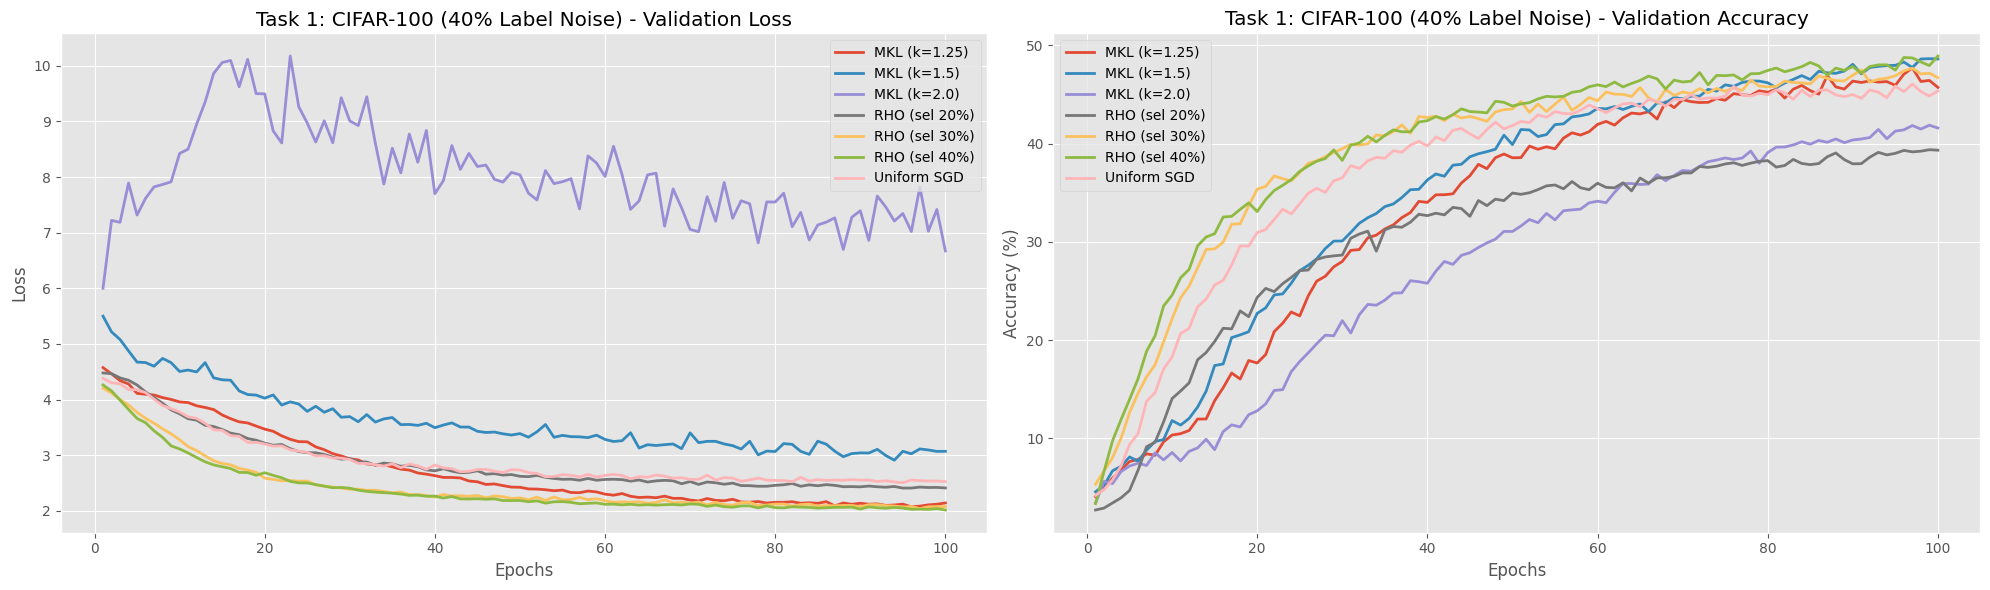


>>> Summary Table: Task 1: CIFAR-100 (40% Label Noise)



################################################################################
VISUALIZATION: Task 2: MNIST (Input Noise std=1.5)
################################################################################


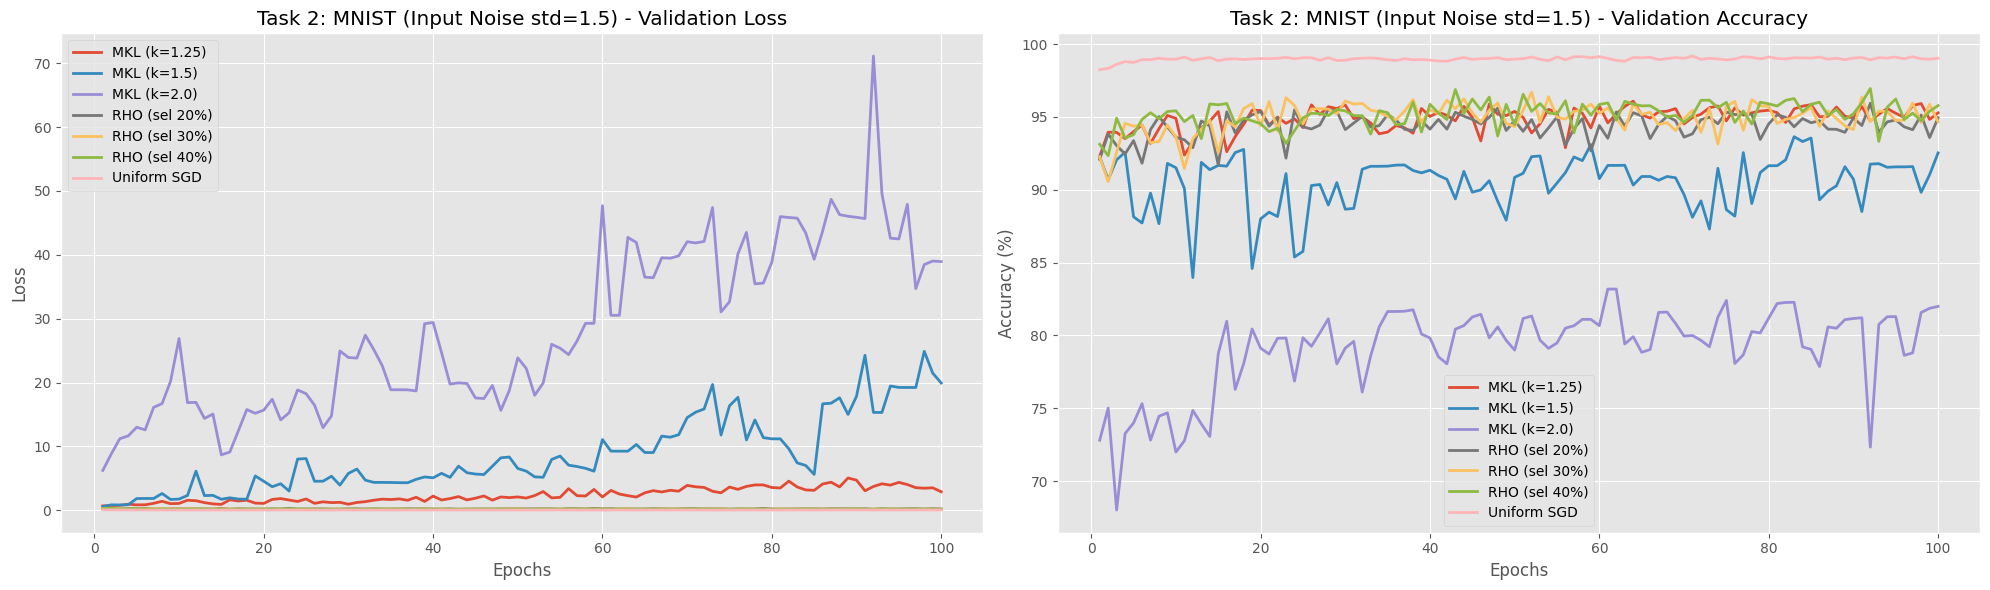


>>> Summary Table: Task 2: MNIST (Input Noise std=1.5)



################################################################################
VISUALIZATION: Task 3: CLOUD (Input Noise std=1.5)
################################################################################


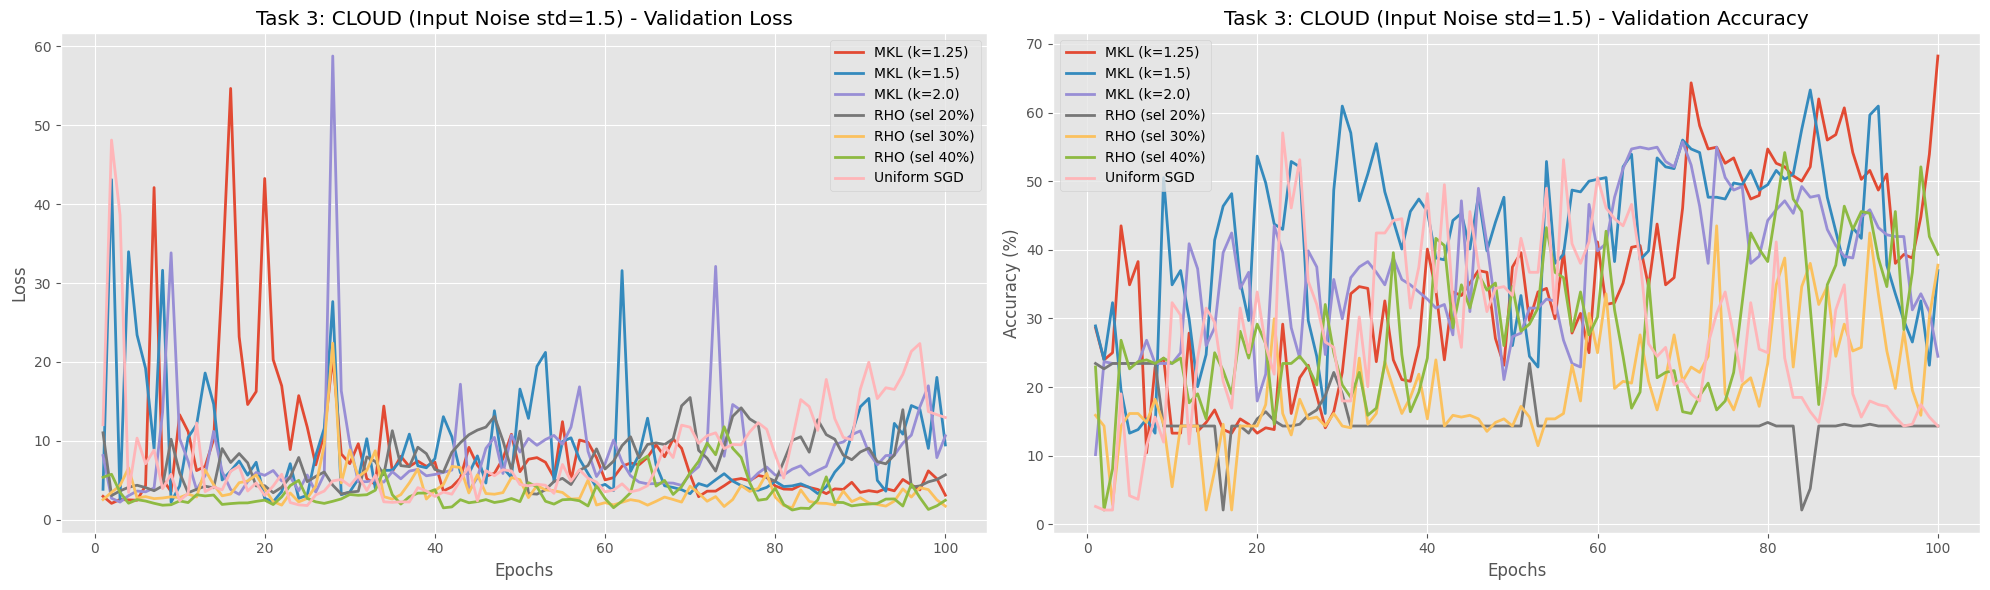


>>> Summary Table: Task 3: CLOUD (Input Noise std=1.5)


In [36]:
# --- 12b. Visualization Functions (Updated & Wrapped) ---
# [ This REPLACES your old Snippet 12 ]

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import display

plt.style.use('ggplot') # Use a nice style for the plots

def plot_results_custom(all_results, algorithm_names, title_prefix=""):
    """
    Plots the training/validation loss and accuracy for a custom list of experiments.
    """
    
    # Find the shortest number of epochs in case one run was cut short
    if not all_results:
        print(f"Skipping plot '{title_prefix}': No results provided.")
        return

    num_epochs = min(len(res['val_loss']) for res in all_results)
    if num_epochs == 0:
        print(f"Skipping plot '{title_prefix}': No epoch data found (all runs may have been skipped).")
        return

    epochs = range(1, num_epochs + 1)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6)) # Wider figure
    
    # --- Plot 1: Loss ---
    ax1.set_title(f"{title_prefix} - Validation Loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    
    for results, name in zip(all_results, algorithm_names):
        # Plot Validation Loss (Solid Line)
        ax1.plot(epochs, results['val_loss'][:num_epochs], label=f'{name}', linewidth=2)
        
    ax1.legend()
    ax1.grid(True)

    # --- Plot 2: Accuracy ---
    ax2.set_title(f"{title_prefix} - Validation Accuracy")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy (%)")
    
    for results, name in zip(all_results, algorithm_names):
        # Plot Validation Accuracy (Solid Line)
        val_acc_percent = [acc * 100 for acc in results['val_acc'][:num_epochs]]
        ax2.plot(epochs, val_acc_percent, label=f'{name}', linewidth=2)
        
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

def create_summary_table(all_results, algorithm_names):
    """
    Creates a pandas DataFrame to summarize the key metrics.
    """
    summary_data = {
        'Algorithm': [],
        'Best Val Acc (%)': [],
        'Epoch': [],
        'Final Val Acc (%)': [],
        'Final Train Acc (%)': []
    }
    
    for results, name in zip(all_results, algorithm_names):
        if not results.get('val_acc'): # Skip if no data
            continue
            
        # Find best validation accuracy and its epoch
        best_val_acc = max(results['val_acc']) * 100
        best_epoch = np.argmax(results['val_acc']) + 1 # +1 for 1-based epoch
        
        # Get final metrics
        final_val_acc = results['val_acc'][-1] * 100
        final_train_acc = results['train_acc'][-1] * 100
        
        summary_data['Algorithm'].append(name)
        summary_data['Best Val Acc (%)'].append(best_val_acc)
        summary_data['Epoch'].append(best_epoch)
        summary_data['Final Val Acc (%)'].append(final_val_acc)
        summary_data['Final Train Acc (%)'].append(final_train_acc)
        
    df = pd.DataFrame(summary_data)
    
    if df.empty:
        print("Summary table is empty.")
        return None

    # Format for better readability
    return df.set_index('Algorithm').style.format({
        'Best Val Acc (%)': '{:.2f}',
        'Final Val Acc (%)': '{:.2f}',
        'Final Train Acc (%)': '{:.2f}'
    }).highlight_max(subset=['Best Val Acc (%)'], color='lightgreen')

# --- Wrapper to Run on Dictionary Data ---
def visualize_all_tasks(experiment_data_dict):
    """
    Iterates through the experiment dictionary and calls the plotting functions.
    """
    if not experiment_data_dict:
        print("No experiment data found to visualize.")
        return

    for task_name, runs_dict in experiment_data_dict.items():
        print("\n" + "#"*80)
        print(f"VISUALIZATION: {task_name}")
        print("#"*80)
        
        # Convert Dictionary to Lists for the plotting functions
        results_list = []
        names_list = []
        
        # Sort keys to make plots consistent (e.g., Uniform first, then MKL, then RHO)
        sorted_keys = sorted(runs_dict.keys())
        
        for algo_name in sorted_keys:
            results_list.append(runs_dict[algo_name])
            names_list.append(algo_name)
            
        # 1. Plot Curves
        plot_results_custom(results_list, names_list, title_prefix=task_name)
        
        # 2. Show Summary Table
        table = create_summary_table(results_list, names_list)
        if table is not None:
            print(f"\n>>> Summary Table: {task_name}")
            display(table)

# --- EXECUTE ---
# Run visualization on the results from Snippet 11b
visualize_all_tasks(all_experiment_results)

## 9. Run Analysis

After your main experiment cell (Snippet 11) has finished running *without* debug mode, all the `results_...` dictionaries will be populated.

Run the cell below to automatically generate your comparison plots and summary table.

--- Generating Full Analysis for All Tasks ---

##################################################
# ANALYSIS FOR: Task 1: CIFAR-100 (Label Noise)
##################################################


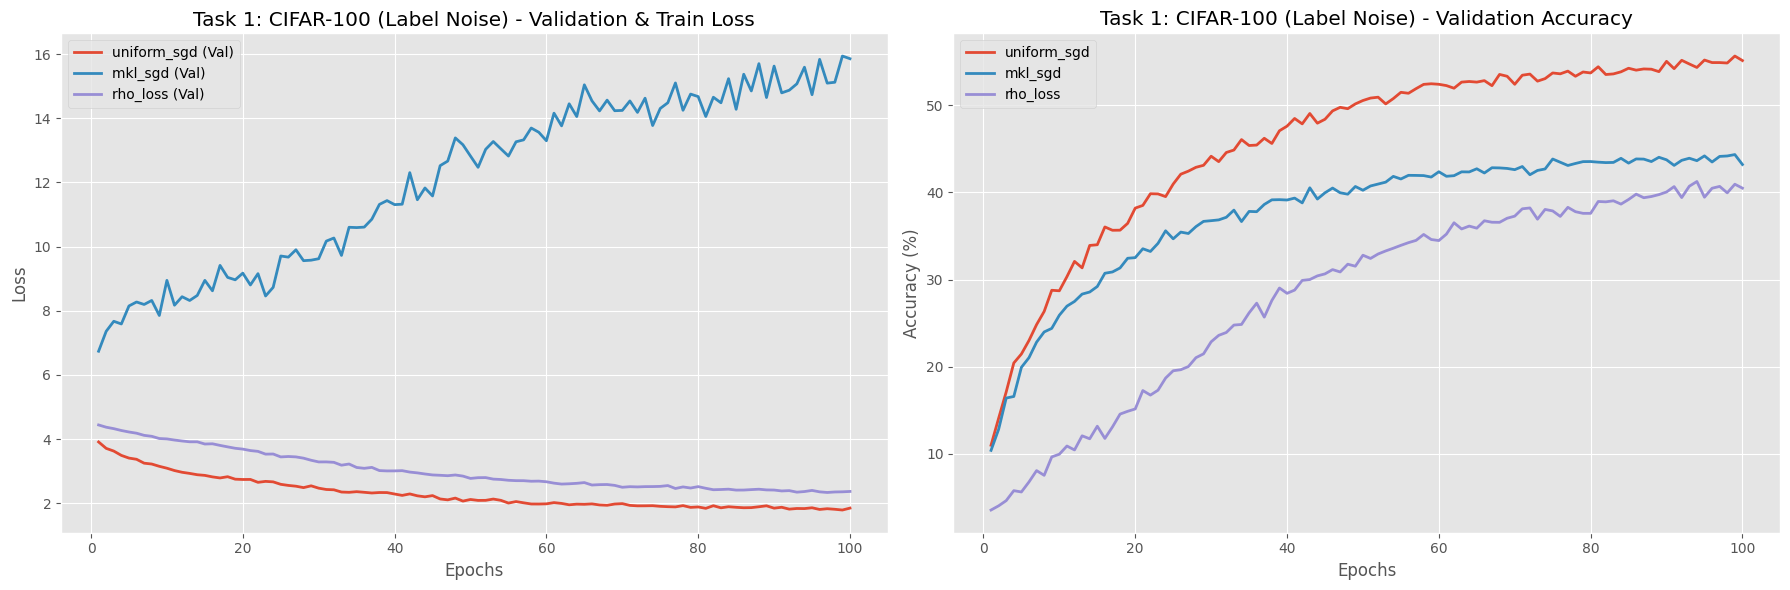


--- Task 1: CIFAR-100 (Label Noise) Summary Table ---






##################################################
# ANALYSIS FOR: Task 2: MNIST (Input Noise)
##################################################


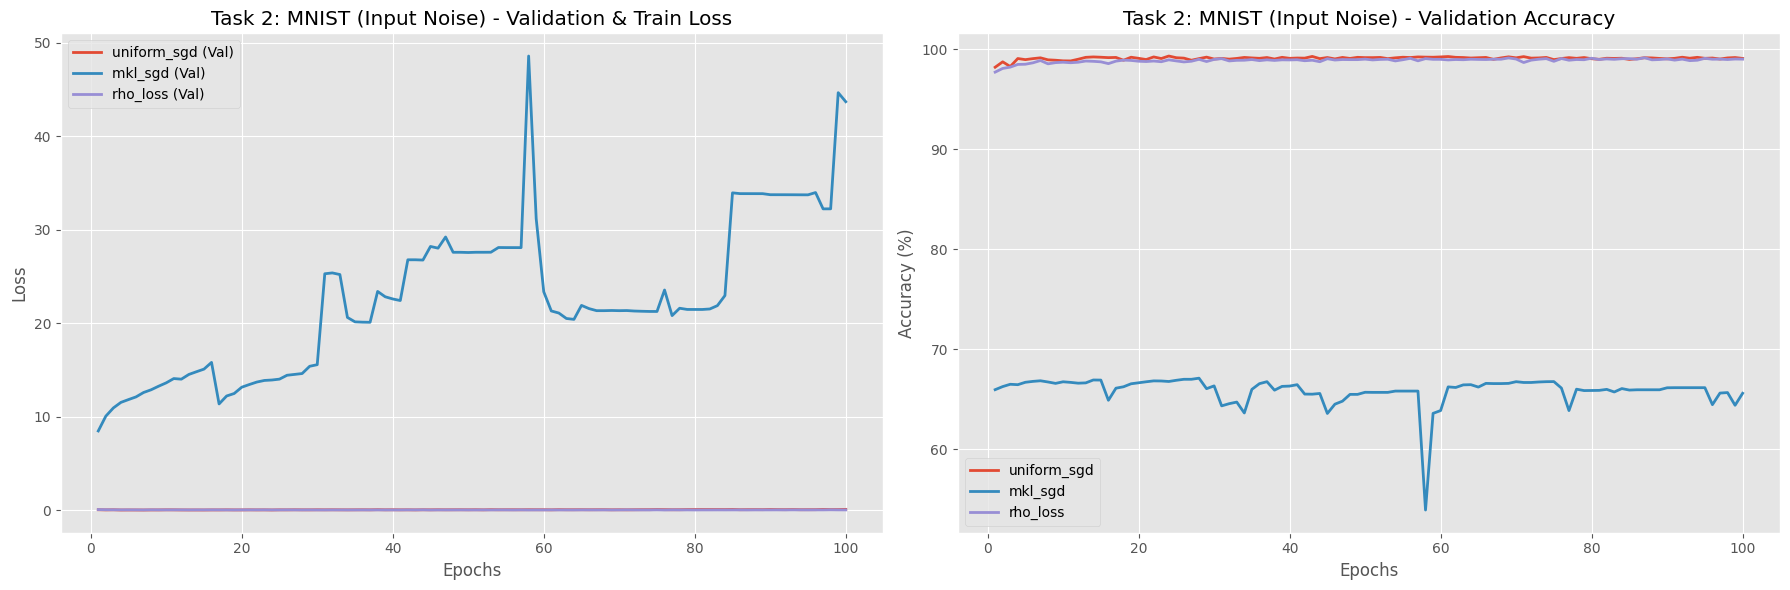


--- Task 2: MNIST (Input Noise) Summary Table ---


In [35]:
# --- 13. Run Analysis (All Experiments) ---
#
# !! RUN THIS CELL AFTER SNIPPET 11 IS DONE !!
#

print("--- Generating Full Analysis for All Tasks ---")

# Loop through each task we completed
for task_name, task_results_dict in all_experiment_results.items():

    print("\n" + "#"*50)
    print(f"# ANALYSIS FOR: {task_name}")
    print("#"*50)

    # 1. Extract the results and names for this task
    # (task_results_dict is e.g., {'uniform_sgd': {...}, 'mkl_sgd': {...}, ...})
    results_list = list(task_results_dict.values())
    algo_names = list(task_results_dict.keys())

    # 2. Generate the plots
    # (Uses the plot_results function from Snippet 12)
    plot_results(
        results_list,
        algo_names,
        title_prefix=task_name
    )

    # 3. Generate and display the summary table
    # (Uses the create_summary_table function from Snippet 12)
    summary_df = create_summary_table(results_list, algo_names)

    print(f"\n--- {task_name} Summary Table ---")
    display(summary_df)
    print("\n\n")

--- Generating Detailed Analysis for HARD MODE ---

################################################################################
# ANALYSIS FOR: Task 1: CIFAR-100 (40% Label Noise)
################################################################################

>>> Full Summary Table: Task 1: CIFAR-100 (40% Label Noise)



>>> Comparative Plot: Best Performers (Task 1: CIFAR-100 (40% Label Noise))


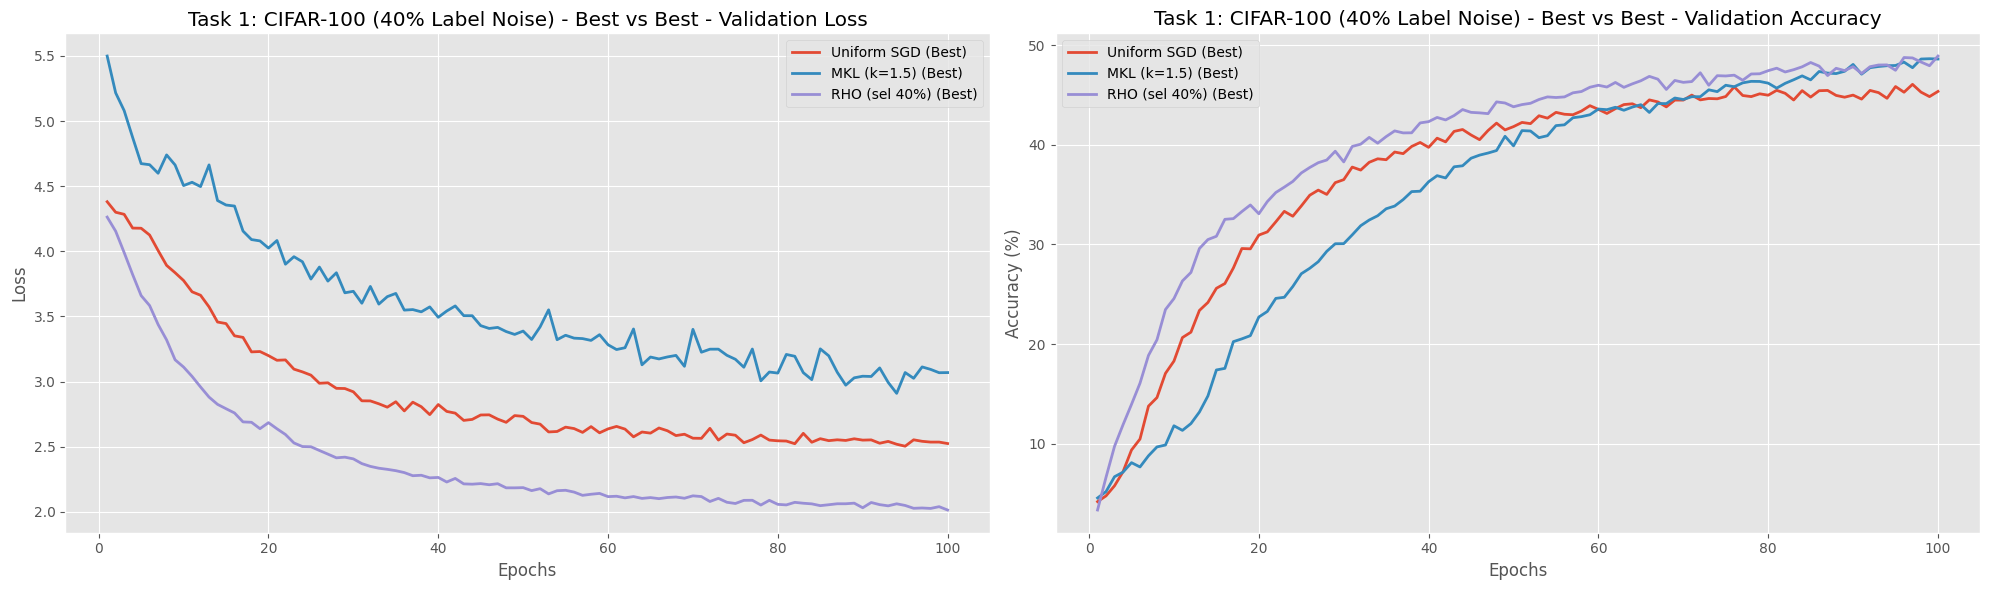


>>> Parameter Sweep: MKL (Task 1: CIFAR-100 (40% Label Noise))


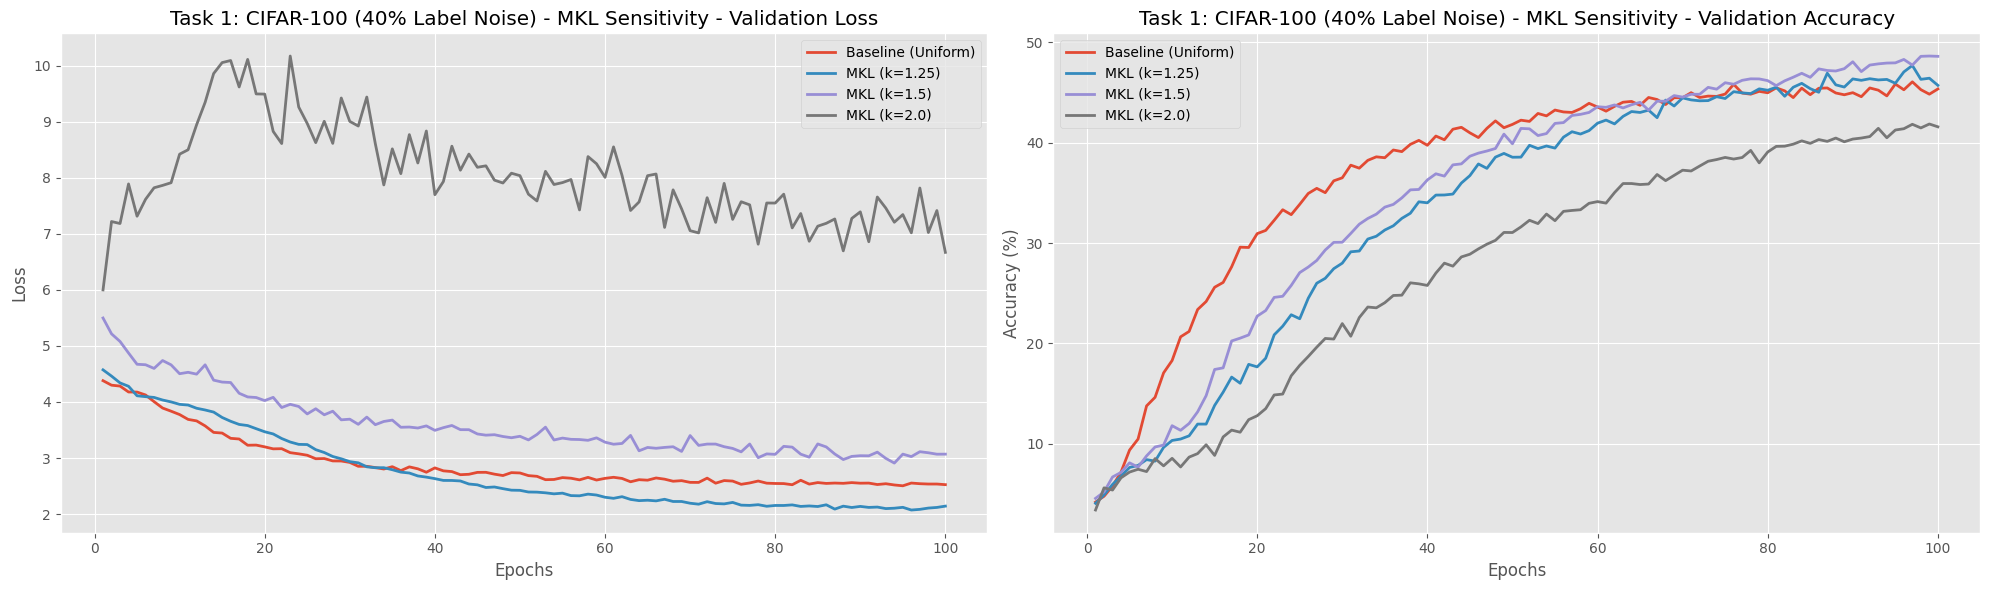


>>> Parameter Sweep: RHO (Task 1: CIFAR-100 (40% Label Noise))


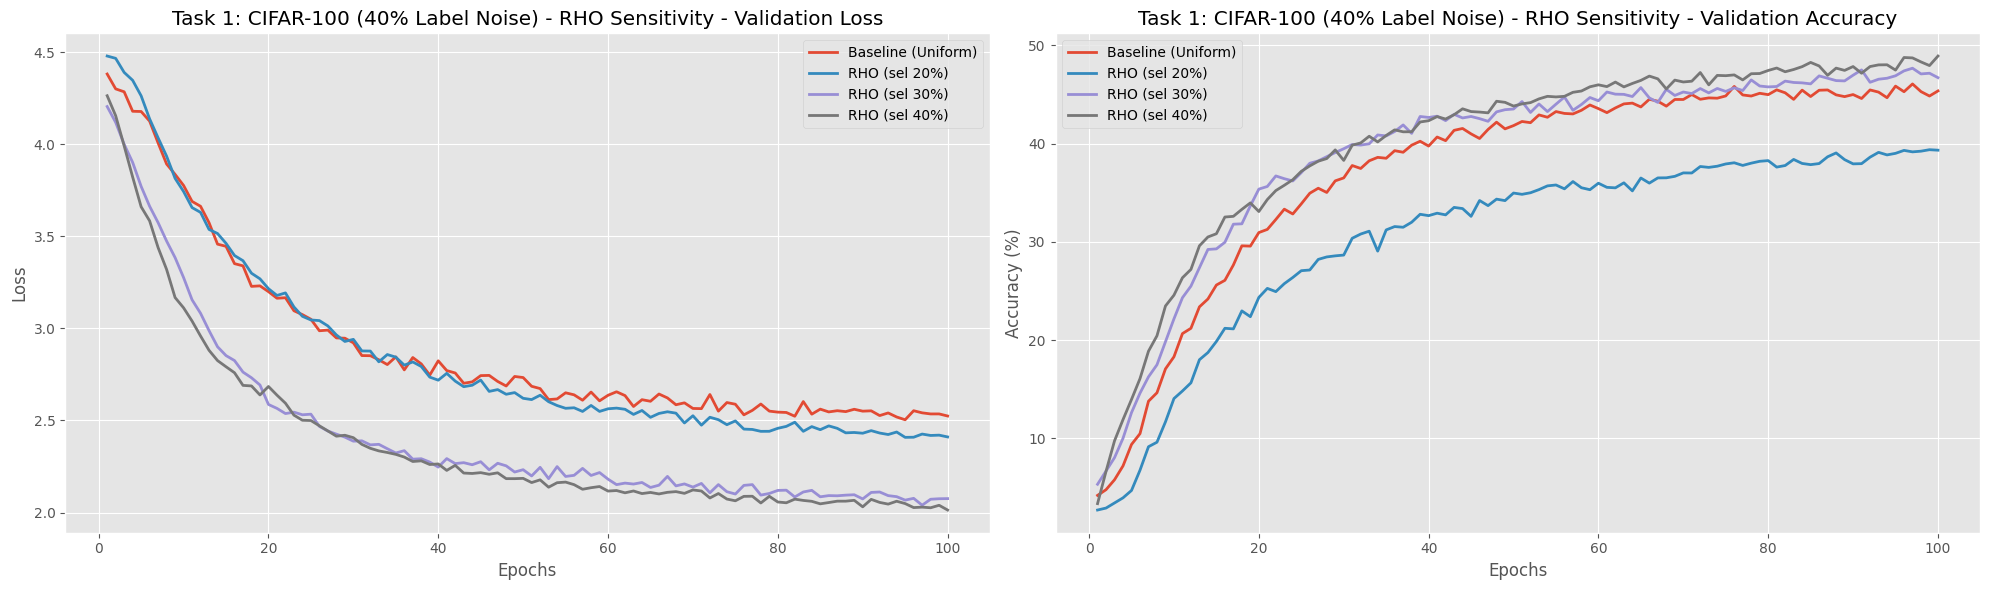


################################################################################
# ANALYSIS FOR: Task 2: MNIST (Input Noise std=1.5)
################################################################################

>>> Full Summary Table: Task 2: MNIST (Input Noise std=1.5)



>>> Comparative Plot: Best Performers (Task 2: MNIST (Input Noise std=1.5))


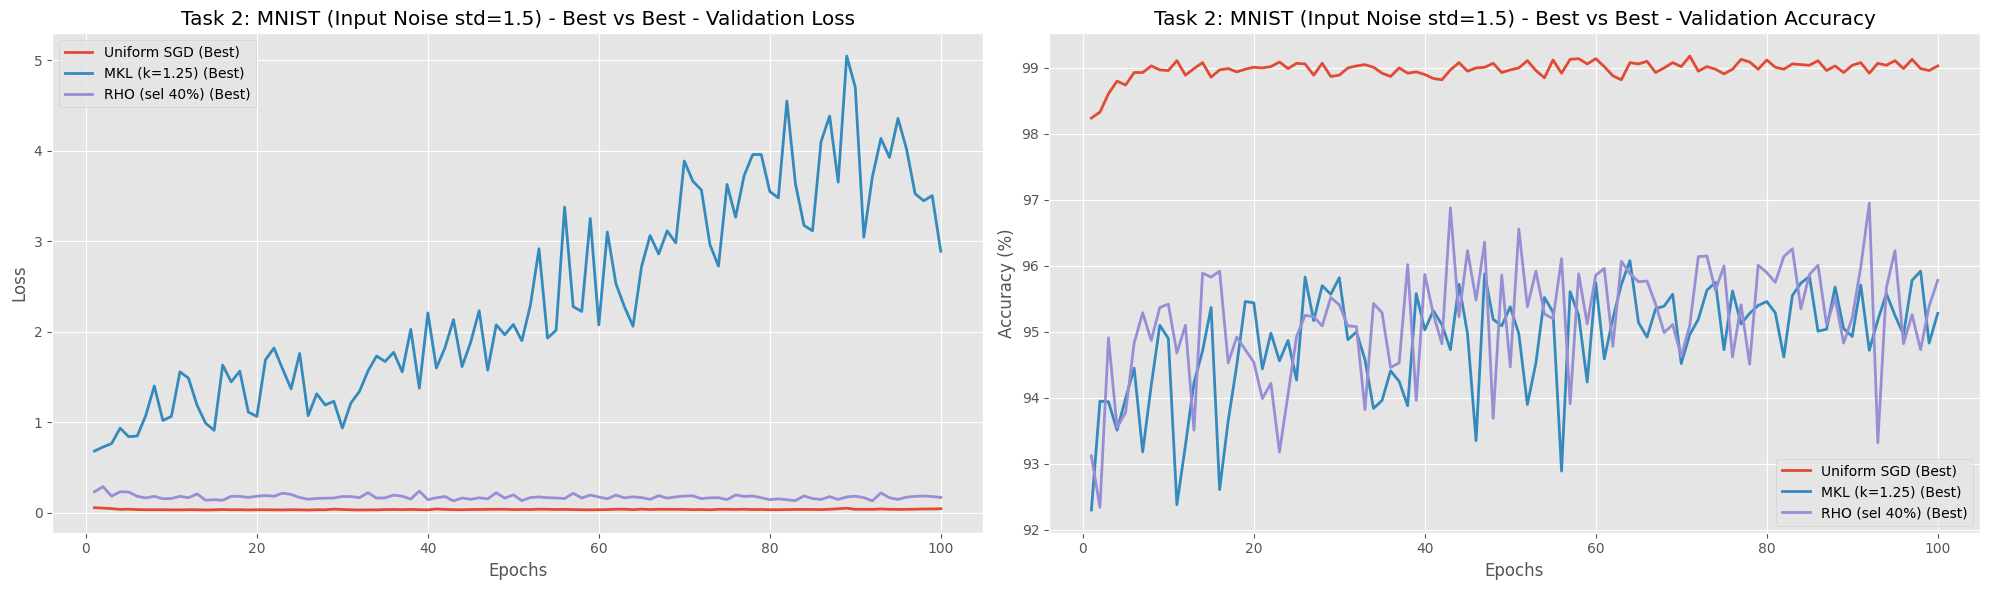


>>> Parameter Sweep: MKL (Task 2: MNIST (Input Noise std=1.5))


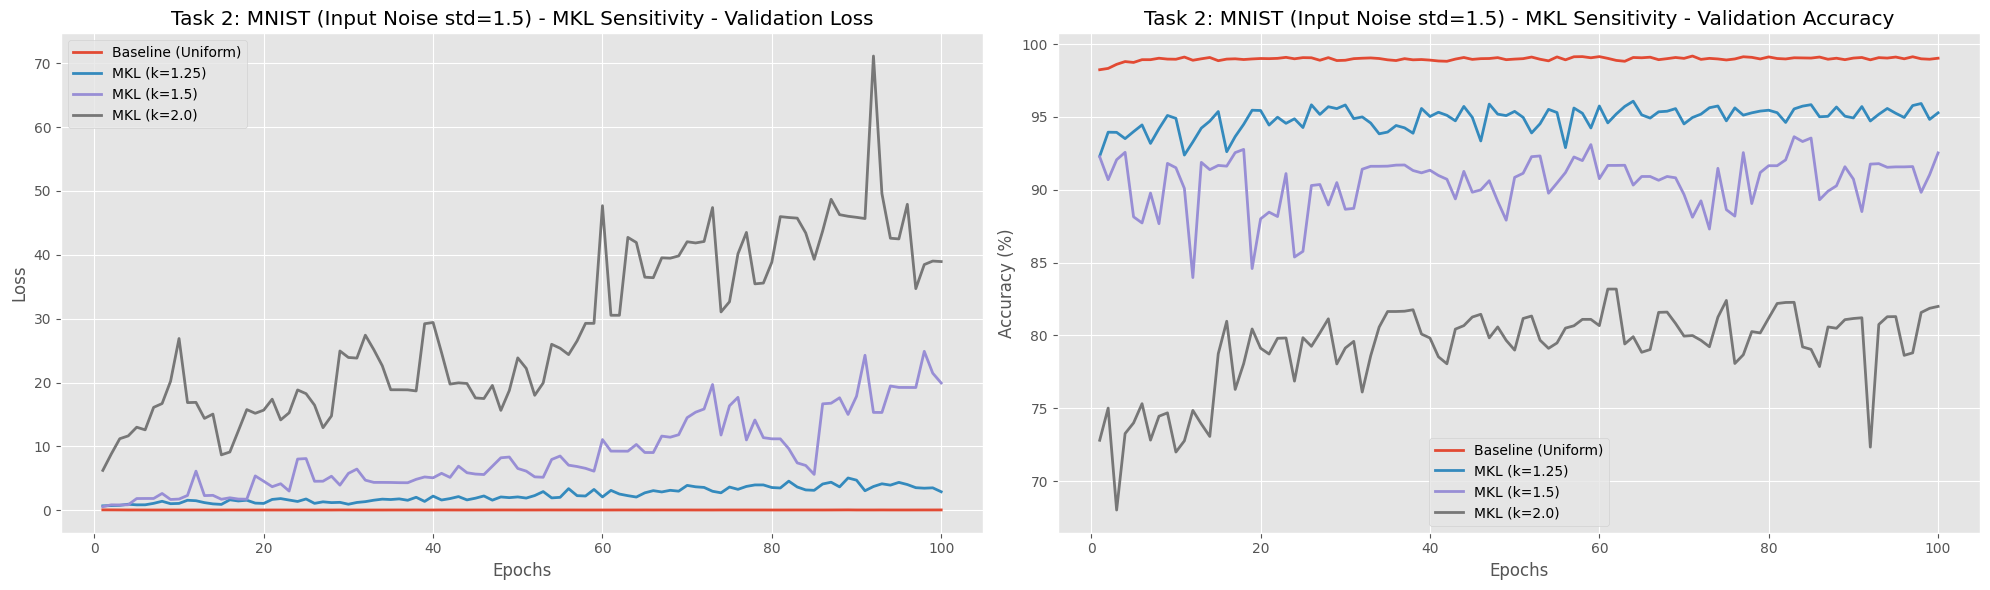


>>> Parameter Sweep: RHO (Task 2: MNIST (Input Noise std=1.5))


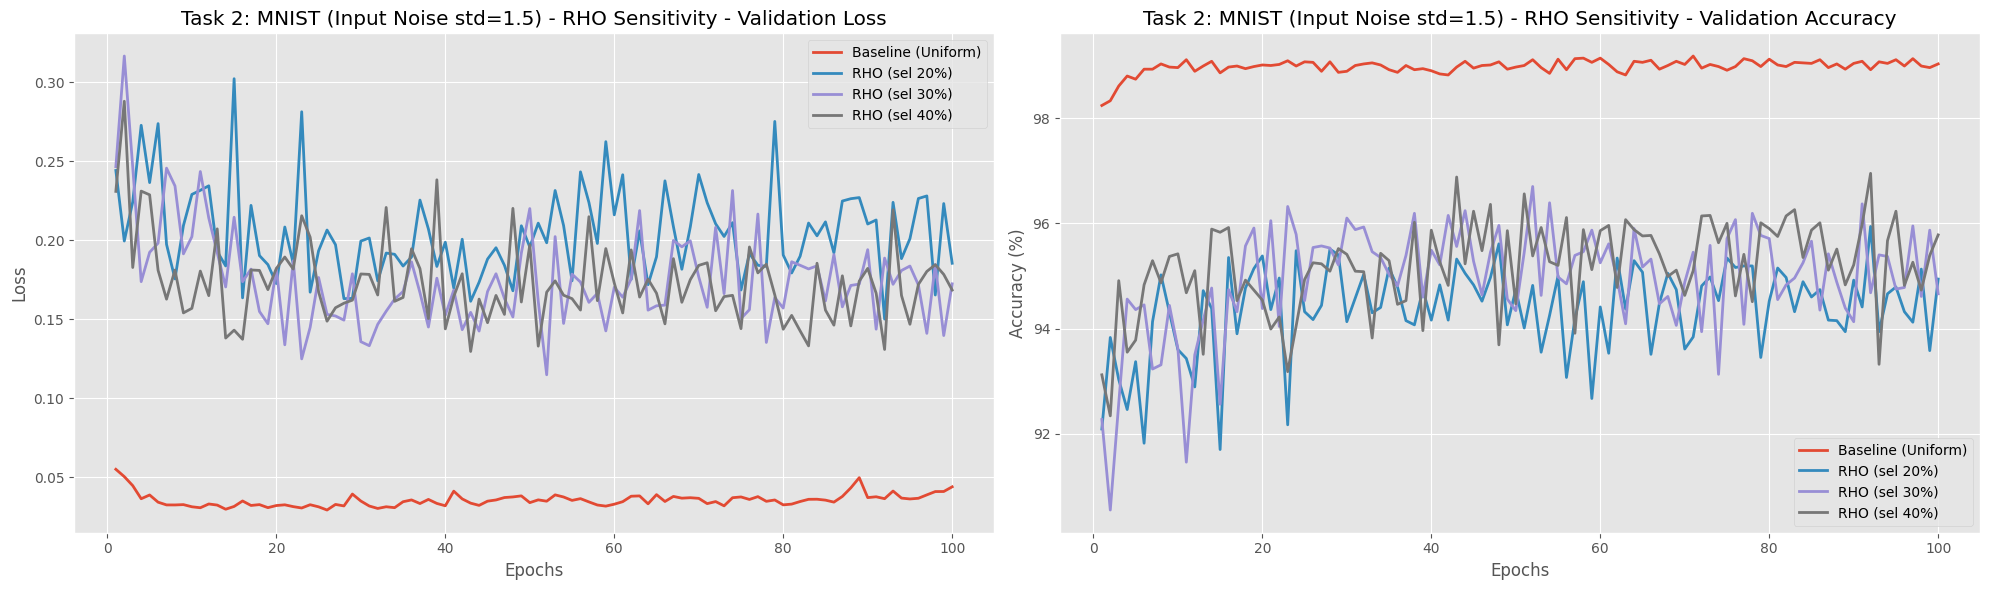


################################################################################
# ANALYSIS FOR: Task 3: CLOUD (Input Noise std=1.5)
################################################################################

>>> Full Summary Table: Task 3: CLOUD (Input Noise std=1.5)



>>> Comparative Plot: Best Performers (Task 3: CLOUD (Input Noise std=1.5))


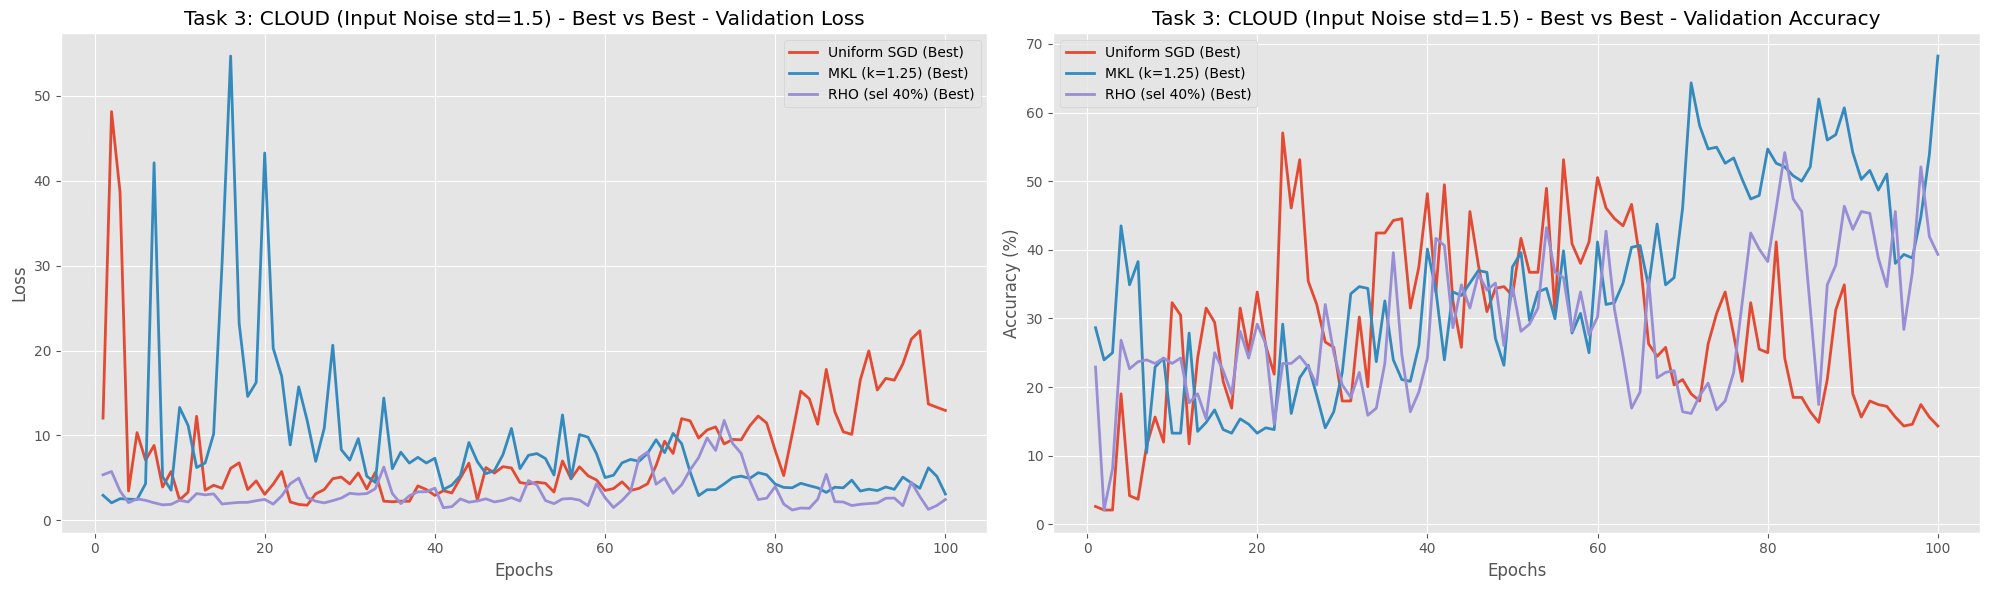


>>> Parameter Sweep: MKL (Task 3: CLOUD (Input Noise std=1.5))


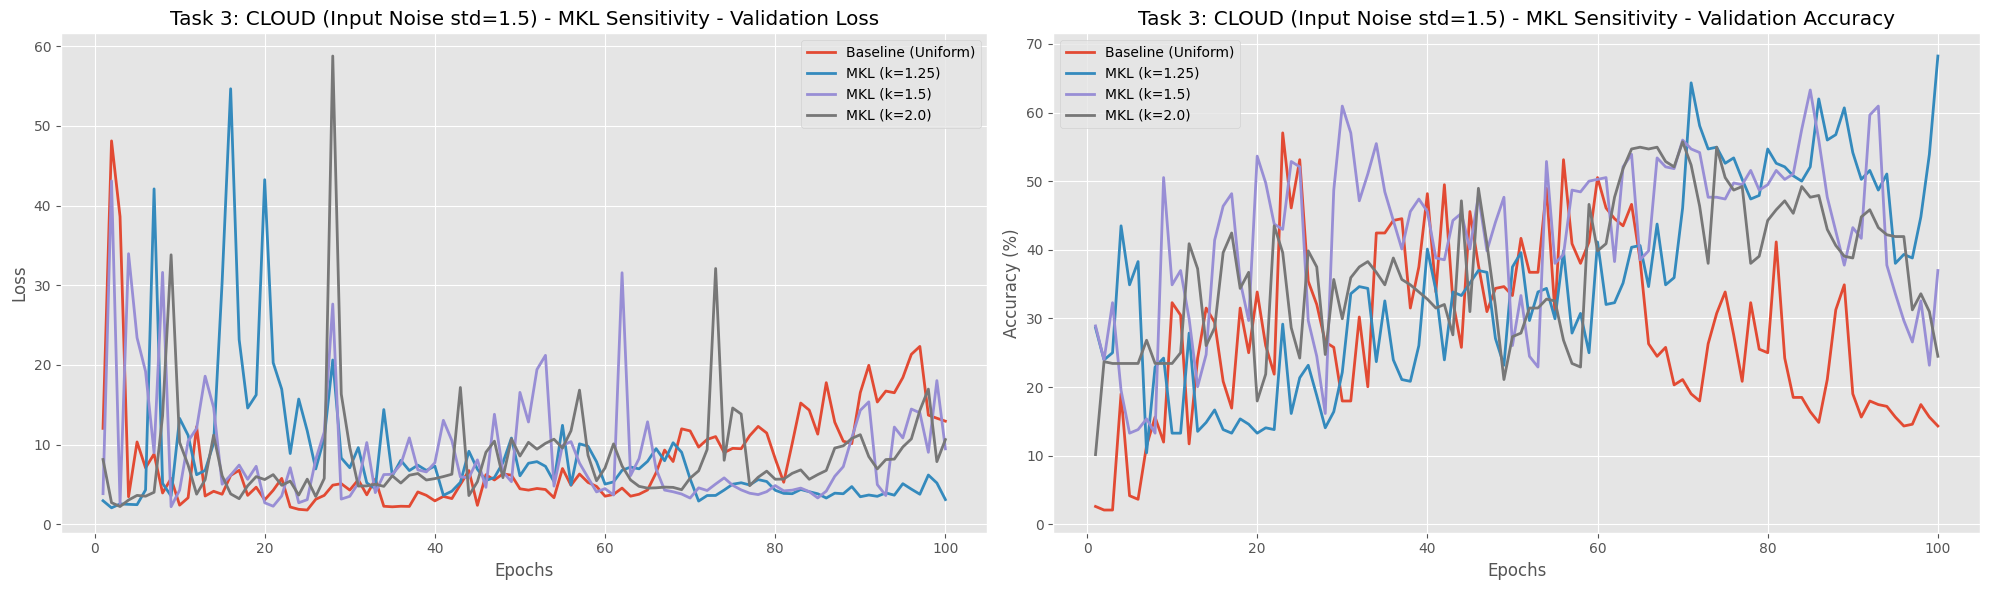


>>> Parameter Sweep: RHO (Task 3: CLOUD (Input Noise std=1.5))


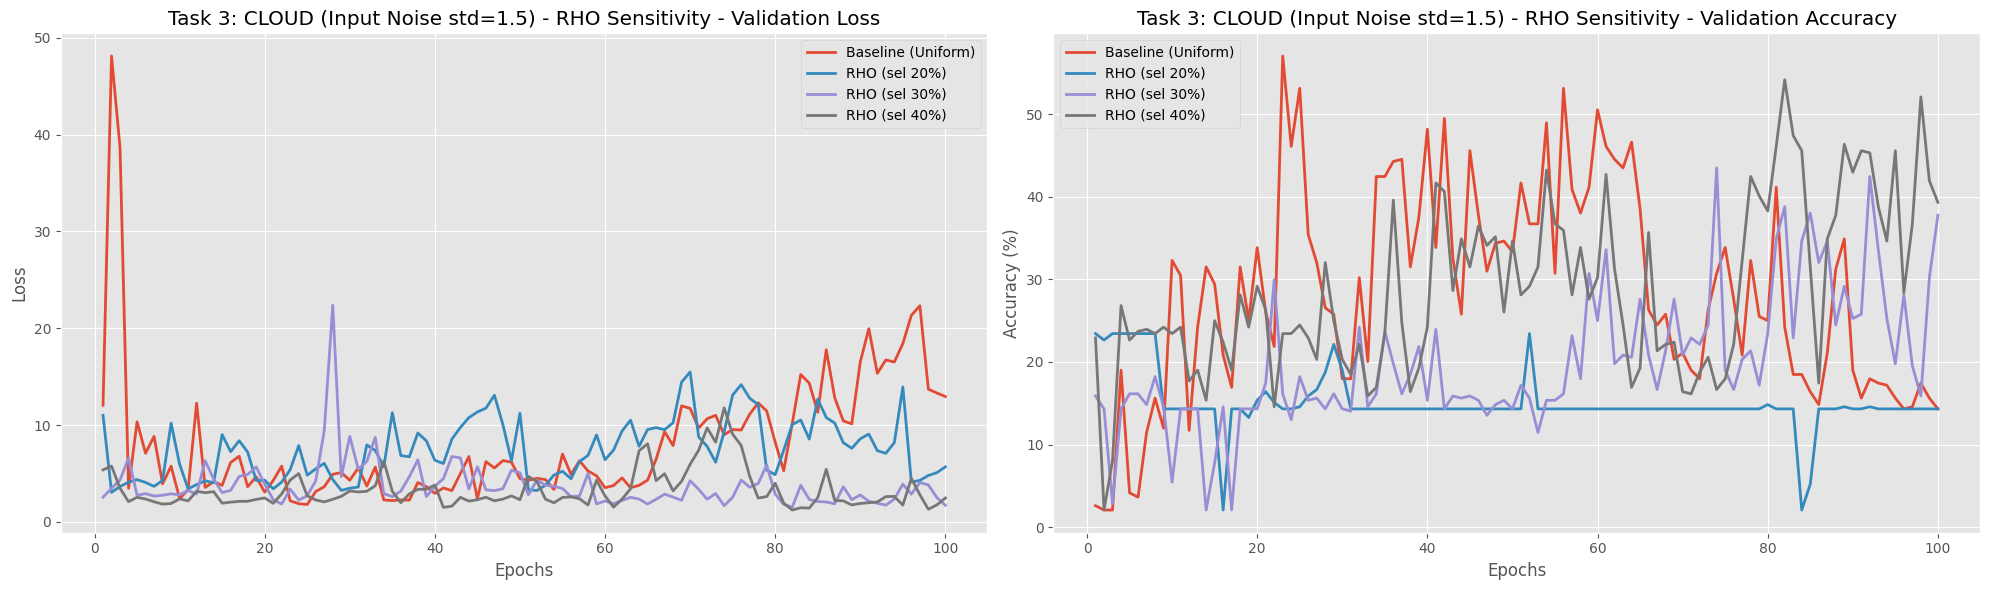

In [37]:
# --- 13b. Run Analysis (Hard Mode - Updated) ---
from IPython.display import display

# --- Helper: Find Best Run ---
def find_best_run(task_results_dict, prefix):
    """
    Finds the best performing run from a sweep based on max validation accuracy.
    Returns: (name_string, results_dict)
    """
    best_acc = -1
    best_name = None
    best_results = None
    
    # Iterate through all runs in this task
    for run_name, results in task_results_dict.items():
        # Check if run matches the prefix (e.g., "MKL")
        if run_name.lower().startswith(prefix.lower()) and results.get('val_acc'):
            max_acc = max(results['val_acc'])
            if max_acc > best_acc:
                best_acc = max_acc
                best_name = run_name
                best_results = results
                
    if best_name:
        # Return the specific best run
        return f"{best_name} (Best)", best_results
    else:
        # Fallback: Return None if not found
        return f"{prefix} (Not Found)", None

print("--- Generating Detailed Analysis for HARD MODE ---")

for task_name, task_results in all_experiment_results.items():
    
    print("\n" + "#"*80)
    print(f"# ANALYSIS FOR: {task_name}")
    print("#"*80)
    
    all_names = list(task_results.keys())
    all_results_list = list(task_results.values())
    
    # 1. Overall Summary Table
    print(f"\n>>> Full Summary Table: {task_name}")
    summary_df = create_summary_table(all_results_list, all_names)
    if summary_df is not None:
        display(summary_df)

    # 2. Plot: Best Uniform vs. Best MKL vs. Best RHO
    # This is the "Money Plot" for the thesis
    print(f"\n>>> Comparative Plot: Best Performers ({task_name})")
    
    name_uni, res_uni = find_best_run(task_results, "Uniform")
    name_mkl, res_mkl = find_best_run(task_results, "MKL")
    name_rho, res_rho = find_best_run(task_results, "RHO")
    
    # Filter out Nones (in case an algorithm wasn't run)
    best_runs = []
    best_names = []
    
    if res_uni: 
        best_runs.append(res_uni)
        best_names.append(name_uni)
    if res_mkl: 
        best_runs.append(res_mkl)
        best_names.append(name_mkl)
    if res_rho: 
        best_runs.append(res_rho)
        best_names.append(name_rho)
        
    if best_runs:
        plot_results_custom(
            best_runs,
            best_names,
            title_prefix=f"{task_name} - Best vs Best"
        )
    else:
        print("Not enough data for comparison plot.")

    # 3. Parameter Sweep Plots
    # A. MKL Sweep
    mkl_names = sorted([n for n in all_names if "MKL" in n])
    if mkl_names:
        print(f"\n>>> Parameter Sweep: MKL ({task_name})")
        # Include Uniform as baseline if available
        sweep_runs = [task_results[n] for n in mkl_names]
        sweep_labels = mkl_names
        
        if res_uni:
            sweep_runs.insert(0, res_uni)
            sweep_labels.insert(0, "Baseline (Uniform)")
            
        plot_results_custom(sweep_runs, sweep_labels, title_prefix=f"{task_name} - MKL Sensitivity")
    
    # B. RHO Sweep
    rho_names = sorted([n for n in all_names if "RHO" in n])
    if rho_names:
        print(f"\n>>> Parameter Sweep: RHO ({task_name})")
        sweep_runs = [task_results[n] for n in rho_names]
        sweep_labels = rho_names
        
        if res_uni:
            sweep_runs.insert(0, res_uni)
            sweep_labels.insert(0, "Baseline (Uniform)")
            
        plot_results_custom(sweep_runs, sweep_labels, title_prefix=f"{task_name} - RHO Sensitivity")

--- Generating Analysis (Labels Corrected to 'Test Acc') ---

################################################################################
# ANALYSIS FOR: Task 1: CIFAR-100 (40% Label Noise)
################################################################################

>>> Full Summary Table: Task 1: CIFAR-100 (40% Label Noise)



>>> Comparative Plot: Best Performers (Task 1: CIFAR-100 (40% Label Noise))


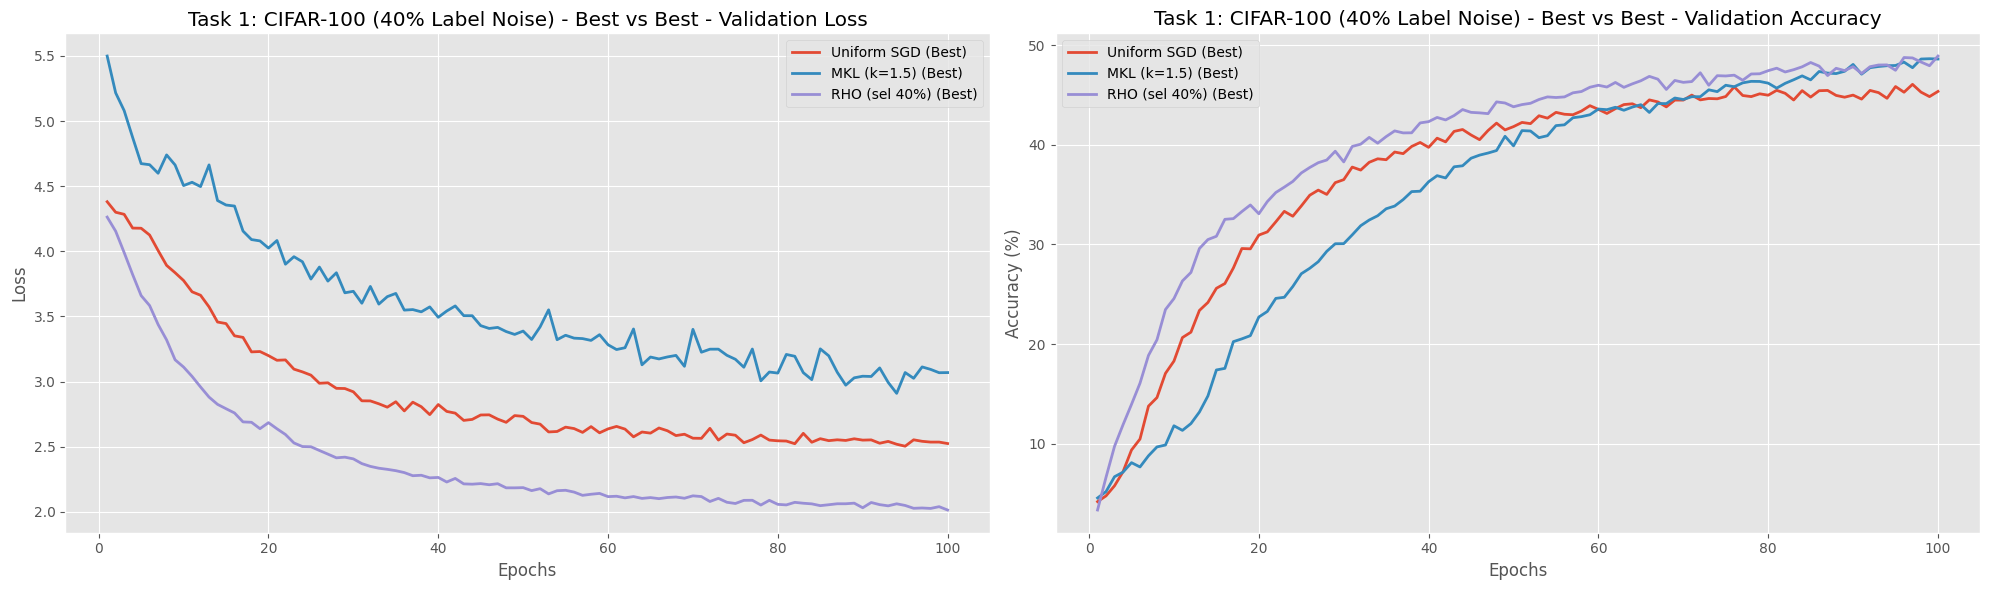


################################################################################
# ANALYSIS FOR: Task 2: MNIST (Input Noise std=1.5)
################################################################################

>>> Full Summary Table: Task 2: MNIST (Input Noise std=1.5)



>>> Comparative Plot: Best Performers (Task 2: MNIST (Input Noise std=1.5))


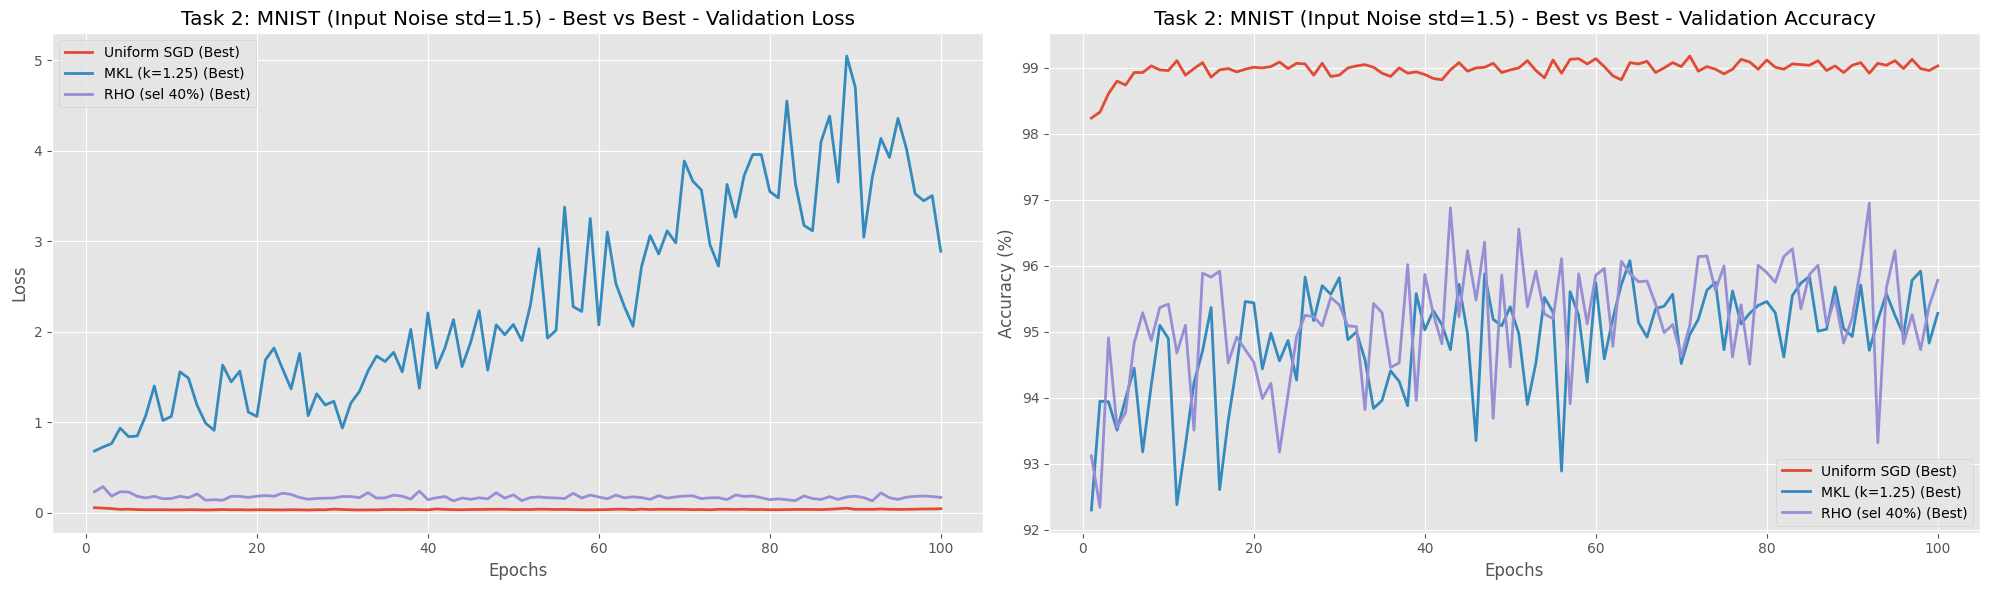


################################################################################
# ANALYSIS FOR: Task 3: CLOUD (Input Noise std=1.5)
################################################################################

>>> Full Summary Table: Task 3: CLOUD (Input Noise std=1.5)



>>> Comparative Plot: Best Performers (Task 3: CLOUD (Input Noise std=1.5))


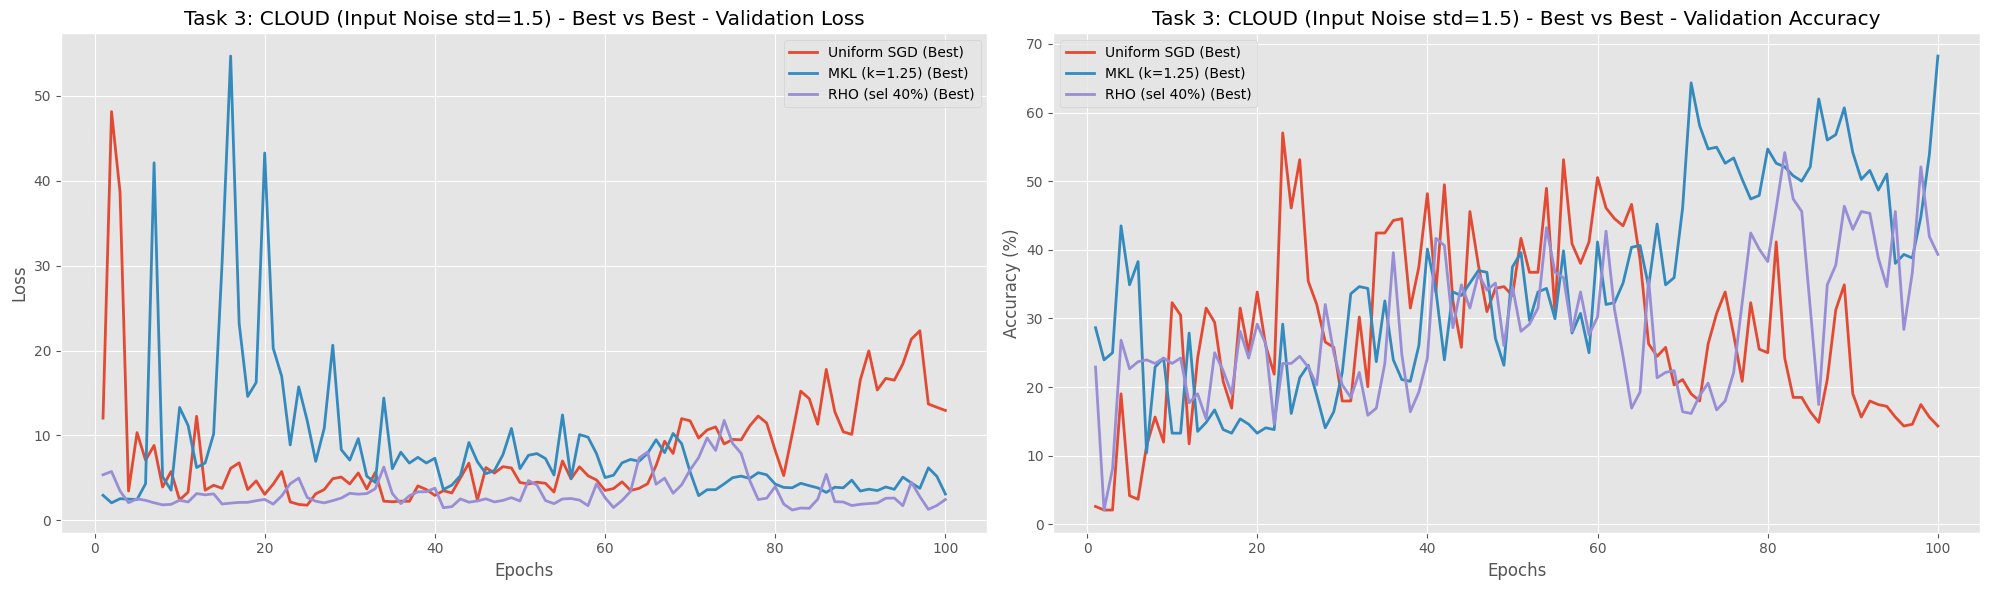

In [38]:
# --- 13c. Run Analysis (Renamed for Clarity) ---
from IPython.display import display

def create_summary_table_renamed(all_results, algorithm_names):
    """
    Creates a summary table with explicit 'Test Accuracy' labels.
    """
    summary_data = {
        'Algorithm': [],
        'Best Test Acc (%)': [],
        'Epoch': [],
        'Final Test Acc (%)': [],
        'Final Train Acc (%)': []
    }
    
    for results, name in zip(all_results, algorithm_names):
        if not results.get('val_acc'): continue
            
        # "val_acc" in the code IS the Test Accuracy (evaluated on test_loader)
        best_test_acc = max(results['val_acc']) * 100
        best_epoch = np.argmax(results['val_acc']) + 1
        final_test_acc = results['val_acc'][-1] * 100
        final_train_acc = results['train_acc'][-1] * 100
        
        summary_data['Algorithm'].append(name)
        summary_data['Best Test Acc (%)'].append(best_test_acc)
        summary_data['Epoch'].append(best_epoch)
        summary_data['Final Test Acc (%)'].append(final_test_acc)
        summary_data['Final Train Acc (%)'].append(final_train_acc)
        
    df = pd.DataFrame(summary_data)
    if df.empty: return None

    return df.set_index('Algorithm').style.format({
        'Best Test Acc (%)': '{:.2f}',
        'Final Test Acc (%)': '{:.2f}',
        'Final Train Acc (%)': '{:.2f}'
    }).highlight_max(subset=['Best Test Acc (%)'], color='lightgreen')

print("--- Generating Analysis (Labels Corrected to 'Test Acc') ---")

for task_name, task_results in all_experiment_results.items():
    
    print("\n" + "#"*80)
    print(f"# ANALYSIS FOR: {task_name}")
    print("#"*80)
    
    all_names = list(task_results.keys())
    all_results_list = list(task_results.values())
    
    # 1. Summary Table
    print(f"\n>>> Full Summary Table: {task_name}")
    summary_df = create_summary_table_renamed(all_results_list, all_names)
    if summary_df is not None:
        display(summary_df)

    # 2. Plot: Best Performers
    print(f"\n>>> Comparative Plot: Best Performers ({task_name})")
    name_uni, res_uni = find_best_run(task_results, "Uniform")
    name_mkl, res_mkl = find_best_run(task_results, "MKL")
    name_rho, res_rho = find_best_run(task_results, "RHO")
    
    best_runs = [r for r in [res_uni, res_mkl, res_rho] if r]
    best_names = [n for n in [name_uni, name_mkl, name_rho] if n]
        
    if best_runs:
        plot_results_custom(best_runs, best_names, title_prefix=f"{task_name} - Best vs Best")

In [42]:
# --- 14. MNIST Signal-to-Noise Calculation ---

import torch
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# 1. Load Clean MNIST Data (Validation set is enough for calculation)
# We use the standard normalization (mean 0.1307, std 0.3081) 
# because that's what the model actually sees.
transform_clean = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)) 
])

# Download just the test set for quick calculation
mnist_calc_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform_clean)
loader = DataLoader(mnist_calc_data, batch_size=1000, shuffle=False)

# 2. Calculate "Signal Power" (E[x^2])
# We calculate the mean of the squared pixels across the dataset
print("--- Calculating MNIST Signal Power ---")
squared_sum = 0.0
total_pixels = 0

for data, _ in loader:
    # data is shape [batch, 1, 28, 28]
    # Square every pixel value
    squared_pixels = data ** 2
    squared_sum += squared_pixels.sum().item()
    total_pixels += data.numel()

# E[X^2] for the Signal
signal_power = squared_sum / total_pixels
print(f"Signal Power (E[x^2] of normalized MNIST): {signal_power:.4f}")

# 3. Compare with Noise Power for different std values
print("\n--- Comparison with Proposed Noise Levels ---")
std_values = [0.5, 1.0, 1.5, 2.0, 2.5]

for std in std_values:
    noise_power = std ** 2  # E[epsilon^2] = variance
    
    # Signal to Noise Ratio (SNR)
    # If SNR < 1, the Noise is stronger than the Signal
    snr = signal_power / noise_power
    
    print(f"std = {std:.1f} | Noise Power: {noise_power:.2f} | SNR: {snr:.4f}")
    
    if snr < 0.2:
        print(f"   -> CRITICAL: Noise is 5x stronger than signal. (X^T X)^-1 approx 0.")
    elif snr < 0.5:
        print(f"   -> HARD: Noise is 2x stronger than signal. Good for robust testing.")
    elif snr < 1.0:
        print(f"   -> MEDIUM: Noise is stronger than signal, but learnable.")
    else:
        print(f"   -> EASY: Signal is stronger than noise (This explains your 99% result).")

--- Calculating MNIST Signal Power ---
Signal Power (E[x^2] of normalized MNIST): 1.0155

--- Comparison with Proposed Noise Levels ---
std = 0.5 | Noise Power: 0.25 | SNR: 4.0622
   -> EASY: Signal is stronger than noise (This explains your 99% result).
std = 1.0 | Noise Power: 1.00 | SNR: 1.0155
   -> EASY: Signal is stronger than noise (This explains your 99% result).
std = 1.5 | Noise Power: 2.25 | SNR: 0.4514
   -> HARD: Noise is 2x stronger than signal. Good for robust testing.
std = 2.0 | Noise Power: 4.00 | SNR: 0.2539
   -> HARD: Noise is 2x stronger than signal. Good for robust testing.
std = 2.5 | Noise Power: 6.25 | SNR: 0.1625
   -> CRITICAL: Noise is 5x stronger than signal. (X^T X)^-1 approx 0.


In [34]:
# --- CLEANUP: Delete ALL Task 3 Experiment Checkpoints ---
import os
import glob

# Define path (Same as your other snippets)
try:
    import google.colab
    BASE_PATH = '/content/drive/MyDrive'
except ImportError:
    BASE_PATH = '.'
    
checkpoint_dir = os.path.join(BASE_PATH, 'ThesisCheckpoints_v2')

# Pattern to find all Task 3 experiment files
# This matches 'task_3_Uniform_SGD.pth', 'task_3_MKL...', etc.
files_to_delete = glob.glob(os.path.join(checkpoint_dir, "task_3_*.pth"))

print(f"Checking {checkpoint_dir}...")
print(f"Found {len(files_to_delete)} old Task 3 experiment checkpoints.")

for f in files_to_delete:
    try:
        os.remove(f)
        print(f"Deleted: {os.path.basename(f)}")
    except OSError as e:
        print(f"Error deleting {f}: {e}")

print("--- Task 3 Cleanup Complete. Safe to run Snippet 11b. ---")

Checking ./ThesisCheckpoints_v2...
Found 14 old Task 3 experiment checkpoints.
Deleted: task_3_MKL_k=1_25.pth
Deleted: task_3_Uniform_SGD_best.pth
Deleted: task_3_MKL_k=1_5_best.pth
Deleted: task_3_MKL_k=2_0_best.pth
Deleted: task_3_RHO_sel_40.pth
Deleted: task_3_MKL_k=1_5.pth
Deleted: task_3_MKL_k=2_0.pth
Deleted: task_3_RHO_sel_30.pth
Deleted: task_3_RHO_sel_20.pth
Deleted: task_3_RHO_sel_20_best.pth
Deleted: task_3_MKL_k=1_25_best.pth
Deleted: task_3_RHO_sel_40_best.pth
Deleted: task_3_RHO_sel_30_best.pth
Deleted: task_3_Uniform_SGD.pth
--- Task 3 Cleanup Complete. Safe to run Snippet 11b. ---
